In [1]:
tracks={}
for no in ['A','B','C','D']:
    tracks[no] = pd.read_csv("dataset/track_" + no + ".csv", parse_dates=["date"])

In [2]:
equipments={}
for no in ['A','B','C','D']:
    equipments[no] = pd.read_csv("dataset/equipment_" + no + ".csv")

In [3]:
import datetime
import random
import sys

In [4]:
def get_day(dates):
    day = [(date - datetime.datetime(2017, 4, 1)).days for date in dates]
    return day

In [5]:
def feature_engineering(df, dmm, mv, admm):
    if dmm:
         df['diff_moving_mean'] = df['高低左'] - df['高低左'].rolling(window=7, min_periods=1, center=True).median()
    if mv:
        df['moving_variance'] = df['高低左'].rolling(window=7, min_periods=1, center=True).kurt()
    if admm:
        df['accumulation_diff_moving_mean'] = np.cumsum(abs(df['高低左'].rolling(window=3, min_periods=1, center=True).median() -
                                                            df['高低左'].rolling(window=15, min_periods=1, center=False).median()))
#         df['accumulation_diff_moving_mean'] = np.cumsum(abs(df['高低左'] -
#                                                             df['高低左'].rolling(window=15, min_periods=1, center=False).median()))
    return df

In [6]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [7]:
def scaling(df, w1, w2, w3, w4):
    df['day'] = ss.fit_transform(df['day'].astype(float).values.reshape(len(df), 1))
    if w1 != 0:
        df['高低左'] = ss.fit_transform(df['高低左'].values.reshape(len(df), 1))*w1
    if w2 != 0:
        df['diff_moving_mean'] = ss.fit_transform(df['diff_moving_mean'].values.reshape(len(df), 1))*w2
    if w3 != 0:
        df['moving_variance'] = df['moving_variance'].fillna(0) #rollingした高低左が全部同じ値のときはNANになる
        df['moving_variance'] = ss.fit_transform(df['moving_variance'].values.reshape(len(df), 1))*w3
    if w4 != 0:
        df['accumulation_diff_moving_mean'] = ss.fit_transform(df['accumulation_diff_moving_mean'].values.reshape(len(df), 1))*w4
    return df

In [8]:
from sklearn.neighbors import KernelDensity
bandwidth = [0.1, 1, 10, 50, 100]
kernel = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
metric = ['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
leaf_size = [10, 40, 400, 4000]
kd = KernelDensity(bandwidth=bandwidth[3], kernel=kernel[0], metric=metric[0], leaf_size=leaf_size[1])

In [9]:
def kd_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99998, False, True)].index.values
    return normal_id

In [10]:
from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=5, random_state=0)
kmeans = KMeans(n_clusters=4, random_state=0)

In [11]:
# def kmeans_outliers_flag(raw):
#     df = raw.copy()
#     df = feature_engineering(df, True, True, True)
#     df = scaling(df, 50, 50, 0.5, 50)
#     kmeans.fit(df)
#     raw['label'] = kmeans.labels_
#     return raw

In [12]:
def kmeans_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, False, True)
#     df = scaling(df, 10, 10, 0, 100)
    df = scaling(df, 10, 50, 0, 100)
    kmeans.fit(df)
    df['label'] = kmeans.labels_
    normal_label = df['label'].mode()[0]
    normal_id = df[df['label'] == normal_label].index.values
    return normal_id

In [13]:
from sklearn.neighbors import LocalOutlierFactor
#algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
#metric = ['minkowsk', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
#lof = LocalOutlierFactor(n_neighbors=20, contamination=0.5, algorithm=algorithm[0], metric=metric[0])
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.5)

In [14]:
def lof_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, False, False)
    df = scaling(df, 10, 50, 0, 0)
    normal_id = df[np.where(lof.fit_predict(df) == -1 , False, True)].index.values
    return normal_id

In [15]:
# def remove_outliers(raw):
#     local_global = [[[], []], [[], []], [[], []]]
#     local_global[0][1].extend(raw.index.values)
#     df1 = raw.copy()
#     local_global[1][1].extend(kd_outliers(df1))

#     df2 = raw.loc[local_global[1][1]]
#     df2 = df2.reset_index(drop=True)
#     local_global[2][0].extend(kmeans_outliers(df2))
#     local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])
#     return local_global[2][1]

In [18]:
def remove_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1)) #Wall time: 14 ms

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(kmeans_outliers(df2)) #Wall time: 44 ms
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(lof_outliers(df3)) #Wall time: 10 ms
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])
    return local_global[3][1]

In [32]:
# fig, axes = plt.subplots(10, 1, figsize=(15, 20), sharex=True)
# random.seed(110)
# track = tracks['A']
# kilos = track['キロ程'].unique()

# # for i, kilo in enumerate(random.sample(list(kilos), 10)):
# for i, kilo in enumerate(kilos[:10]):
#     data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
#     data = data.dropna(subset=['高低左'])
#     data = data.reset_index(drop=True)
#     data['day'] = get_day(data['date'])
#     data = data.drop(['date'], axis=1)

# #    if len(data) < 4:
#     if len(data) < 8:
#         print(i)
#         continue

#     normal = remove_outliers(data)
#     datal = data.loc[normal]

#     axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='r')
#     axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')
#     axes[i].set_title(f'{kilo}')

In [22]:
# fig, axes = plt.subplots(100, 1, figsize=(15, 200), sharex=True)
# random.seed(110)
# track = tracks['A']
# kilos = track['キロ程'].unique()

# for i, kilo in enumerate(random.sample(list(kilos), 100)):
#     data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
#     data = data.dropna(subset=['高低左'])
#     data = data.reset_index(drop=True)
#     data['day'] = get_day(data['date'])
#     data = data.drop(['date'], axis=1)

# #    if len(data) < 4:
#     if len(data) < 8:
#         print(i)
#         continue

#     normal = remove_outliers(data)
#     datal = data.loc[normal]

#     axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='r')
#     axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')

In [ ]:
# fig, axes = plt.subplots(100, 1, figsize=(15, 200), sharex=True)
# random.seed(110)
# track = tracks['D']
# kilos = track['キロ程'].unique()

# for i, kilo in enumerate(random.sample(list(kilos), 100)):
#     data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
#     data = data.dropna(subset=['高低左'])
#     data = data.reset_index(drop=True)
#     data['day'] = get_day(data['date'])
#     data = data.drop(['date'], axis=1)

# #    if len(data) < 4:
#     if len(data) < 8:
#         print(i)
#         continue

#     alll = data.index.values
#     normal = kd_outliers(data)
#     out = set(data.index.values) - set(normal)
#     datao = data.loc[out]
#     data = data.loc[normal]

#     final = kmeans_outliers(data)
#     data_final = data.loc[final]

#     data = kmeans_outliers_flag(data)

#     axes[i].plot(datao['day'], datao['高低左'], marker='.', linewidth=0, c='k', alpha=0.5)
#     axes[i].plot(data.loc[data['label'] == 0, 'day'], data.loc[data['label'] == 0, '高低左'], marker='.', linewidth=0, c='b' ,alpha=0.5)
#     axes[i].plot(data.loc[data['label'] == 1, 'day'], data.loc[data['label'] == 1, '高低左'], marker='.', linewidth=0, c='g' ,alpha=0.5)
#     axes[i].plot(data.loc[data['label'] == 2, 'day'], data.loc[data['label'] == 2, '高低左'], marker='.', linewidth=0, c='r' ,alpha=0.5)
#     axes[i].plot(data.loc[data['label'] == 3, 'day'], data.loc[data['label'] == 3, '高低左'], marker='.', linewidth=0, c='c' ,alpha=0.5)
# #     axes[i].plot(data.loc[data['label'] == 4, 'day'], data.loc[data['label'] == 4, '高低左'], marker='.', linewidth=0, c='m' ,alpha=0.5)
#     axes[i].plot(data_final['day'], data_final['高低左'], marker='.', linewidth=0, c='y')

In [ ]:
# fig, axes = plt.subplots(100, 1, figsize=(15, 200), sharex=True)
# random.seed(110)
# track = tracks['D']
# kilos = track['キロ程'].unique()

# for i, kilo in enumerate(random.sample(list(kilos), 100)):
#     data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
#     data = data.dropna(subset=['高低左'])
#     data = data.reset_index(drop=True)
#     data['day'] = get_day(data['date'])
#     data = data.drop(['date'], axis=1)

# #    if len(data) < 4:
#     if len(data) < 8:
#         print(i)
#         continue

#     alll = data.index.values
#     normal = kd_outliers1(data)
#     out = set(data.index.values) - set(normal)

#     datao = data.loc[out]
#     data = data.loc[normal]

#     data = kmeans_outliers_flag(data)

#     axes[i].plot(datao['day'], datao['高低左'], marker='.', linewidth=0, c='k', alpha=0.5)
#     axes[i].plot(data.loc[data['label'] == 0, 'day'], data.loc[data['label'] == 0, '高低左'], marker='.', linewidth=0, c='b')
#     axes[i].plot(data.loc[data['label'] == 1, 'day'], data.loc[data['label'] == 1, '高低左'], marker='.', linewidth=0, c='g')
#     axes[i].plot(data.loc[data['label'] == 2, 'day'], data.loc[data['label'] == 2, '高低左'], marker='.', linewidth=0, c='r')
#     axes[i].plot(data.loc[data['label'] == 3, 'day'], data.loc[data['label'] == 3, '高低左'], marker='.', linewidth=0, c='c')
#     axes[i].plot(data.loc[data['label'] == 4, 'day'], data.loc[data['label'] == 4, '高低左'], marker='.', linewidth=0, c='m')

In [ ]:
# fig, axes = plt.subplots(50, 1, figsize=(15, 100), sharex=True)
# random.seed(110)
# track = tracks['A']
# kilos = track['キロ程'].unique()

# for i, kilo in enumerate(random.sample(list(kilos), 50)):
#     data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
#     data = data.dropna(subset=['高低左'])
#     data = data.reset_index(drop=True)
#     data['day'] = get_day(data['date'])
#     data = data.drop(['date'], axis=1)
#     if len(data) < 20:
#         print(i)
#         continue

#     alll = data.index.values
#     normal = flag_outliers(data)
#     out = set(data.index.values) - set(normal)

#     datao1 = data.loc[out1]
#     datal = data.loc[normal]

#     axes[i].plot(datao1['day'], datao1['高低左'], marker='.', linewidth=0, c='c')
#     axes[i].plot(datao2['day'], datao2['高低左'], marker='.', linewidth=0, c='g')
#     axes[i].plot(datao3['day'], datao3['高低左'], marker='.', linewidth=0, c='r')
#     axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')

In [24]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [25]:
def get_slope(day, koutei):
    if len(day) == 0:
        print('!!!!!   no data... why?   !!!!!\n*10')
        return -100
    X = day
    X = [[x] for x in X]
    y = koutei

    lr.fit(X, y)
    slope = lr.coef_[0]

    return slope

In [26]:
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [27]:
from tqdm import tqdm

In [33]:
%%time
random.seed(0)

for no in tqdm(['A', 'B', 'C', 'D']):
    track = tracks[no]
    equipment = equipments[no]
    track = track.dropna(subset=['高低左'])
    track = track.reset_index(drop=True)

#     kilos = track['キロ程'].unique()[:100]
# #     kilos = random.sample(list(track['キロ程'].unique()), 100)
#     track = track[track['キロ程'].isin(kilos)]
#     track = track.reset_index(drop=True)
#     equipment = equipment[equipment['キロ程'].isin(kilos)]
#     equipment = equipment.reset_index(drop=True)

    kilos = track['キロ程'].unique()

    slopes = []
    sokuteis = []
    last_medians = []
    num_datas = []
    sigmas = []
    for kilo in tqdm(kilos):
        data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
        data = data.dropna(subset=['高低左'])
        data = data.reset_index(drop=True)
        data['day'] = get_day(data['date'])
        data = data.drop('date', axis=1)
        sokutei = len(data)
        sokuteis.append(sokutei)
        kouteis = data['高低左'].values
#         last_median = np.median(kouteis[-30:])
        last_median = np.median(0)
        last_medians.append(last_median)
        sigma = kouteis[-30:].std(ddof=1)
        sigmas.append(sigma)
        if sokutei < 30:
            num_data = -100
            num_datas.append(num_data)
            slope = -100
            slopes.append(slope)
            continue

        normal_id = remove_outliers(data)
        data = data.loc[normal_id]
        data = data.reset_index(drop=True)
        num_data = len(data)
        num_datas.append(num_data)
        if num_data < 6:
            print('!!!   len(data) < 6 after remove_outliers   !!!')
            print(no, kilo)
            slope = -100
            slopes.append(slope)
            continue
        days = data['day']
        kouteis = data['高低左']
        slope = get_slope(days, kouteis)
        slopes.append(slope)

    summary = pd.DataFrame(columns=['路線', 'キロ程', '傾き', '切片', '標本標準偏差', '測定回数', 'データ数'])
    summary['キロ程'] = kilos
    summary['路線'] = no
    summary['切片'] = last_medians
    summary['測定回数'] = sokuteis
    summary['データ数'] = num_datas
    summary['傾き'] = slopes
    summary['標本標準偏差'] = sigmas

    summary = pd.concat([summary, equipment.drop('キロ程', axis=1)], axis=1)
    summary.to_csv(f'summary5_{no}.csv')

  1%|          | 330/27612 [00:44<49:22,  9.21it/s]


  2%|▏         | 671/27612 [01:25<58:46,  7.64it/s]


  4%|▍         | 1046/27612 [02:10<1:13:56,  5.99it/s]


  5%|▌         | 1510/27612 [02:59<42:58, 10.12it/s]


  7%|▋         | 2067/27612 [03:51<39:37, 10.75it/s]


  9%|▉         | 2467/27612 [04:31<29:12, 14.35it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

  9%|▉         | 2471/27612 [04:31<31:24, 13.34it/s]

!!!   len(data) < 6 after remove_outliers   !!!
A 12565



 11%|█         | 2941/27612 [05:17<51:09,  8.04it/s]


 13%|█▎        | 3458/27612 [06:07<47:52,  8.41it/s]


 14%|█▍        | 3951/27612 [06:55<43:42,  9.02it/s]


 16%|█▌        | 4324/27612 [07:37<45:00,  8.62it/s]


 16%|█▌        | 4339/27612 [07:38<38:23, 10.10it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 18%|█▊        | 4885/27612 [08:28<33:55, 11.17it/s]


 20%|█▉        | 5437/27612 [09:19<40:39,  9.09it/s]


 22%|██▏       | 5984/27612 [10:10<31:13, 11.54it/s]


 22%|██▏       | 6134/27612 [10:23<26:37, 13.45it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 24%|██▍       | 6559/27612 [11:01<31:37, 11.09it/s]


 26%|██▌       | 7137/27612 [11:53<30:18, 11.26it/s]


 28%|██▊       | 7715/27612 [12:45<28:41, 11.56it/s]


 30%|███       | 8299/27612 [13:37<29:21, 10.96it/s]


 32%|███▏      | 8865/27612 [14:30<29:40, 10.53it/s]


 34%|███▍      | 9381/27612 [15:19<26:59, 11.25it/s]


 36%|███▌      | 9965/27612 [16:14<27:38, 10.64it/s]


 38%|███▊      | 10539/27612 [17:06<25:01, 11.37it/s]


 40%|████      | 11080/27612 [34:51<49:16,  5.59it/s]


 42%|████▏     | 11483/27612 [35:35<25:04, 10.72it/s]


 44%|████▎     | 12012/27612 [36:26<24:13, 10.73it/s]


 45%|████▌     | 12544/27612 [37:15<22:21, 11.24it/s]


 48%|████▊     | 13116/27612 [38:06<22:30, 10.74it/s]


 50%|████▉     | 13688/27612 [38:57<20:27, 11.34it/s]


 52%|█████▏    | 14241/27612 [39:49<20:53, 10.67it/s]


 54%|█████▎    | 14810/27612 [40:42<20:06, 10.61it/s]


 54%|█████▍    | 14934/27612 [40:53<18:43, 11.29it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 56%|█████▌    | 15372/27612 [41:34<18:59, 10.74it/s]


 58%|█████▊    | 15881/27612 [42:22<18:46, 10.42it/s]


 60%|█████▉    | 16453/27612 [43:16<17:49, 10.43it/s]


 62%|██████▏   | 17021/27612 [44:08<17:09, 10.29it/s]


 62%|██████▏   | 17157/27612 [44:21<15:17, 11.40it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 64%|██████▎   | 17551/27612 [44:57<15:34, 10.77it/s]


 66%|██████▌   | 18124/27612 [56:02<10:20:40,  3.92s/it]


 67%|██████▋   | 18583/27612 [56:49<14:28, 10.39it/s]


 69%|██████▉   | 19155/27612 [57:42<12:21, 11.41it/s]


 71%|███████▏  | 19727/27612 [58:34<12:11, 10.78it/s]


 73%|███████▎  | 20283/27612 [59:26<12:36,  9.68it/s]


 75%|███████▌  | 20825/27612 [1:00:16<10:16, 11.00it/s]


 77%|███████▋  | 21124/27612 [1:00:44<10:08, 10.66it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 77%|███████▋  | 21332/27612 [1:01:03<09:41, 10.79it/s]


 79%|███████▉  | 21884/27612 [1:01:54<08:46, 10.89it/s]


 81%|████████  | 22387/27612 [1:02:42<07:59, 10.90it/s]


 83%|████████▎ | 22911/27612 [1:03:31<07:21, 10.65it/s]


 85%|████████▍ | 23421/27612 [1:04:19<07:37,  9.15it/s]


 87%|████████▋ | 23939/27612 [1:05:08<05:30, 11.13it/s]


 89%|████████▊ | 24491/27612 [1:05:58<04:43, 11.02it/s]


 91%|█████████ | 25039/27612 [1:39:35<148:05:26, 207.20s/it]


 93%|█████████▎| 25607/27612 [1:40:20<02:45, 12.13it/s]


 94%|█████████▍| 25953/27612 [1:49:07<03:20,  8.29it/s]


 95%|█████████▍| 26117/27612 [1:49:22<02:19, 10.74it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▍| 26119/27612 [1:49:23<02:15, 11.02it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▍| 26121/27612 [1:49:23<02:05, 11.87it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors,

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▍| 26133/27612 [1:49:24<01:55, 12.86it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▍| 26135/27612 [1:49:24<01:50, 13.42it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
A 26518
!!!   len(data) < 6 after remove_outliers   !!!
A 26519
!!!   len(data) < 6 after remove_outliers   !!!
A 26520


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▍| 26201/27612 [1:49:27<01:03, 22.26it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
A 26524
!!!   len(data) < 6 after remove_outliers   !!!
A 26525
!!!   len(data) < 6 after remove_outliers   !!!
A 26526


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▍| 26208/27612 [1:49:28<01:27, 16.05it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
A 26528
!!!   len(data) < 6 after remove_outliers   !!!
A 26530



 95%|█████████▍| 26211/27612 [1:49:28<01:36, 14.55it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▍| 26213/27612 [1:49:28<01:50, 12.68it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▍| 26216/27612 [1:49:28<01:

!!!   len(data) < 6 after remove_outliers   !!!
A 28003
!!!   len(data) < 6 after remove_outliers   !!!
A 28005


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▍| 26222/27612 [1:49:28<01:15, 18.42it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▍| 26225/27612 [1:49:29<01:20, 17.33it/s]

!!!   len(data) < 6 after remove_outliers   !!!
A 28010
!!!   len(data) < 6 after remove_outliers   !!!
A 28012
!!!   len(data) < 6 after remove_outliers   !!!
A 28013


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▍| 26228/27612 [1:49:29<01:17, 17.94it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
A 28016
!!!   len(data) < 6 after remove_outliers   !!!
A 28017
!!!   len(data) < 6 after remove_outliers   !!!
A 28018


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26232/27612 [1:49:29<01:40, 13.69it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


!!!   len(data) < 6 after remove_outliers   !!!
A 28019
!!!   len(data) < 6 after remove_outliers   !!!
A 28020


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26234/27612 [1:49:29<01:43, 13.37it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26236/27612 [1:49:29<01:44, 13.19it/s]

!!!   len(data) < 6 after remove_outliers   !!!
A 28022
!!!   len(data) < 6 after remove_outliers   !!!
A 28023
!!!   len(data) < 6 after remove_outliers   !!!
A 28024


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26238/27612 [1:49:30<01:48, 12.62it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


!!!   len(data) < 6 after remove_outliers   !!!
A 28025
!!!   len(data) < 6 after remove_outliers   !!!
A 28026
!!!   len(data) < 6 after remove_outliers   !!!
A 28027


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26240/27612 [1:49:30<01:45, 13.06it/s]

!!!   len(data) < 6 after remove_outliers   !!!
A 28028


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26261/27612 [1:49:31<00:59, 22.53it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26265/27612 [1:49:31<00:53, 24.96it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
A 28225
!!!   len(data) < 6 after remove_outliers   !!!
A 28226
!!!   len(data) < 6 after remove_outliers   !!!
A 28228


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26269/27612 [1:49:31<01:04, 20.79it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


!!!   len(data) < 6 after remove_outliers   !!!
A 28229
!!!   len(data) < 6 after remove_outliers   !!!
A 28230


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26272/27612 [1:49:31<01:14, 17.95it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


!!!   len(data) < 6 after remove_outliers   !!!
A 28232
!!!   len(data) < 6 after remove_outliers   !!!
A 28233
!!!   len(data) < 6 after remove_outliers   !!!
A 28481



 95%|█████████▌| 26304/27612 [1:49:32<00:33, 38.57it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26309/27612 [1:49:32<00:51, 25.50it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
A 28632
!!!   len(data) < 6 after remove_outliers   !!!
A 28635


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than th

!!!   len(data) < 6 after remove_outliers   !!!
A 28636
!!!   len(data) < 6 after remove_outliers   !!!
A 28637
!!!   len(data) < 6 after remove_outliers   !!!
A 28638


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26320/27612 [1:49:33<01:14, 17.43it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
A 28640
!!!   len(data) < 6 after remove_outliers   !!!
A 28642


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26326/27612 [1:49:33<01:24, 15.26it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
A 28645


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26328/27612 [1:49:34<01:26, 14.81it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26330/27612 [1:49:34<01:27, 14.64it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
A 28649
!!!   len(data) < 6 after remove_outliers   !!!
A 28651


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26332/27612 [1:49:34<01:29, 14.29it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26334/27612 [1:49:34<01:41, 12.61it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
A 28655
!!!   len(data) < 6 after remove_outliers   !!!
A 28656


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26338/27612 [1:49:34<01:46, 11.99it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26340/27612 [1:49:35<01:49, 11.63it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26342/27612 [1:49:35<01:

!!!   len(data) < 6 after remove_outliers   !!!
A 30491


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26358/27612 [1:49:35<00:58, 21.34it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


!!!   len(data) < 6 after remove_outliers   !!!
A 30501
!!!   len(data) < 6 after remove_outliers   !!!
A 30502


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26362/27612 [1:49:36<01:01, 20.35it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
A 30508
!!!   len(data) < 6 after remove_outliers   !!!
A 30510


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 95%|█████████▌| 26368/27612 [1:49:36<01:13, 16.88it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


!!!   len(data) < 6 after remove_outliers   !!!
A 30511
!!!   len(data) < 6 after remove_outliers   !!!
A 30512


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 96%|█████████▌| 26443/27612 [1:49:40<00:31, 36.93it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 96%|█████████▌| 26507/27612 [1:49:43<00:31, 34.53it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
A 32972



 96%|█████████▌| 26525/27612 [1:49:44<01:03, 17.03it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 96%|█████████▌| 26531/27612 [1:49:45<01:10, 15.39it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 96%|█████████▌| 26541/27612 [1:49:46<01:25, 12.59it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors

!!!   len(data) < 6 after remove_outliers   !!!
A 28480
!!!   len(data) < 6 after remove_outliers   !!!
A 28482
!!!   len(data) < 6 after remove_outliers   !!!
A 28483


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 96%|█████████▋| 26597/27612 [1:49:50<01:10, 14.30it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
A 28484
!!!   len(data) < 6 after remove_outliers   !!!
A 28486



 96%|█████████▋| 26599/27612 [1:49:50<01:10, 14.39it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 96%|█████████▋| 26601/27612 [1:49:50<01:08, 14.67it/s]

!!!   len(data) < 6 after remove_outliers   !!!
A 28487
!!!   len(data) < 6 after remove_outliers   !!!
A 28489


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 96%|█████████▋| 26603/27612 [1:49:51<01:11, 14.04it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


!!!   len(data) < 6 after remove_outliers   !!!
A 28490
!!!   len(data) < 6 after remove_outliers   !!!
A 28491


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 96%|█████████▋| 26605/27612 [1:49:51<01:12, 13.91it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 96%|█████████▋| 26607/27612 [1:49:51<01:12, 13.95it/s]

!!!   len(data) < 6 after remove_outliers   !!!
A 28493
!!!   len(data) < 6 after remove_outliers   !!!
A 28494
!!!   len(data) < 6 after remove_outliers   !!!
A 28495


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 96%|█████████▋| 26614/27612 [1:49:51<00:51, 19.39it/s]

!!!   len(data) < 6 after remove_outliers   !!!
A 28496



 96%|█████████▋| 26619/27612 [1:49:51<00:42, 23.43it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 96%|█████████▋| 26623/27612 [1:49:51<00:45, 21.93it/s]

!!!   len(data) < 6 after remove_outliers   !!!
A 28510



 97%|█████████▋| 26679/27612 [1:49:56<01:17, 12.12it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 26681/27612 [1:49:56<01:13, 12.73it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 26683/27612 [1:49:57<01:

!!!   len(data) < 6 after remove_outliers   !!!
A 32905


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 26736/27612 [1:50:01<01:27,  9.98it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 26738/27612 [1:50:01<01:18, 11.14it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
A 11368
!!!   len(data) < 6 after remove_outliers   !!!
A 19416



 97%|█████████▋| 26858/27612 [1:50:12<00:53, 14.09it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 26860/27612 [1:50:12<00:50, 14.93it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 26877/27612 [1:50:12<00:26, 28.01it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/_m

!!!   len(data) < 6 after remove_outliers   !!!
A 16433
!!!   len(data) < 6 after remove_outliers   !!!
A 32281
!!!   len(data) < 6 after remove_outliers   !!!
A 32282


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 26910/27612 [1:50:13<00:24, 28.86it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
A 32283
!!!   len(data) < 6 after remove_outliers   !!!
A 32284
!!!   len(data) < 6 after remove_outliers   !!!
A 32285
!!!   len(data) < 6 after remove_outliers   !!!
A 32286


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 26914/27612 [1:50:13<00:26, 26.76it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 26924/27612 [1:50:13<00:20, 33.78it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 26928/27612 [1:50:14<00:

!!!   len(data) < 6 after remove_outliers   !!!
A 14039
!!!   len(data) < 6 after remove_outliers   !!!
A 14041
!!!   len(data) < 6 after remove_outliers   !!!
A 14042


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 26944/27612 [1:50:15<00:33, 19.82it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.p

!!!   len(data) < 6 after remove_outliers   !!!
A 14043
!!!   len(data) < 6 after remove_outliers   !!!
A 14044
!!!   len(data) < 6 after remove_outliers   !!!
A 14045
!!!   len(data) < 6 after remove_outliers   !!!
A 14046


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 26947/27612 [1:50:15<00:33, 19.58it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
A 14047
!!!   len(data) < 6 after remove_outliers   !!!
A 14048
!!!   len(data) < 6 after remove_outliers   !!!
A 14049
!!!   len(data) < 6 after remove_outliers   !!!
A 14050


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 26950/27612 [1:50:15<00:34, 19.39it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.p

!!!   len(data) < 6 after remove_outliers   !!!
A 14051
!!!   len(data) < 6 after remove_outliers   !!!
A 14052
!!!   len(data) < 6 after remove_outliers   !!!
A 14053
!!!   len(data) < 6 after remove_outliers   !!!
A 14054


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 26958/27612 [1:50:15<00:28, 22.61it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 26962/27612 [1:50:15<00:25, 25.76it/s]

!!!   len(data) < 6 after remove_outliers   !!!
A 14055



 98%|█████████▊| 26983/27612 [1:50:16<00:14, 42.97it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 26990/27612 [1:50:16<00:13, 45.74it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


!!!   len(data) < 6 after remove_outliers   !!!
A 28145



 98%|█████████▊| 27001/27612 [1:50:16<00:22, 27.27it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 27005/27612 [1:50:16<00:21, 27.65it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 27009/27612 [1:50:17<00:

!!!   len(data) < 6 after remove_outliers   !!!
A 12591



 98%|█████████▊| 27022/27612 [1:50:17<00:26, 21.99it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 27026/27612 [1:50:17<00:24, 23.99it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
A 13075



 98%|█████████▊| 27032/27612 [1:50:18<00:25, 22.38it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 27037/27612 [1:50:18<00:22, 25.09it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
A 14088


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 27043/27612 [1:50:18<00:25, 22.20it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 27048/27612 [1:50:18<00:21, 26.36it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
A 14614
!!!   len(data) < 6 after remove_outliers   !!!
A 14616
!!!   len(data) < 6 after remove_outliers   !!!
A 14617


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 27052/27612 [1:50:18<00:24, 23.11it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
A 16482


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 27070/27612 [1:50:19<00:23, 22.60it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 27078/27612 [1:50:19<00:19, 27.39it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
A 16951
!!!   len(data) < 6 after remove_outliers   !!!
A 16954
!!!   len(data) < 6 after remove_outliers   !!!
A 16955



 98%|█████████▊| 27103/27612 [1:50:20<00:15, 31.97it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 27109/27612 [1:50:20<00:14, 35.72it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-la

!!!   len(data) < 6 after remove_outliers   !!!
A 19437
!!!   len(data) < 6 after remove_outliers   !!!
A 19438
!!!   len(data) < 6 after remove_outliers   !!!
A 19439
!!!   len(data) < 6 after remove_outliers   !!!
A 19440


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 27114/27612 [1:50:20<00:17, 28.29it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
A 19443



 98%|█████████▊| 27126/27612 [1:50:21<00:14, 32.85it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
A 19617
!!!   len(data) < 6 after remove_outliers   !!!
A 19619


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 27143/27612 [1:50:21<00:14, 32.00it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
A 20167
!!!   len(data) < 6 after remove_outliers   !!!
A 20168
!!!   len(data) < 6 after remove_outliers   !!!
A 20169
!!!   len(data) < 6 after remove_outliers   !!!
A 20170


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 27152/27612 [1:50:22<00:18, 25.15it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
A 22369
!!!   len(data) < 6 after remove_outliers   !!!
A 22370


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 27178/27612 [1:50:22<00:11, 36.23it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
A 22464


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 27197/27612 [1:50:23<00:09, 42.19it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
A 23089
!!!   len(data) < 6 after remove_outliers   !!!
A 23090
!!!   len(data) < 6 after remove_outliers   !!!
A 23091


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 27210/27612 [1:50:23<00:09, 40.98it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.p

!!!   len(data) < 6 after remove_outliers   !!!
A 24659
!!!   len(data) < 6 after remove_outliers   !!!
A 24660
!!!   len(data) < 6 after remove_outliers   !!!
A 24661
!!!   len(data) < 6 after remove_outliers   !!!
A 24662


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 27215/27612 [1:50:23<00:13, 30.14it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
A 24663
!!!   len(data) < 6 after remove_outliers   !!!
A 24664
!!!   len(data) < 6 after remove_outliers   !!!
A 24665
!!!   len(data) < 6 after remove_outliers   !!!
A 24666


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 27273/27612 [1:50:24<00:05, 57.44it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 27280/27612 [1:50:24<00:05, 55.67it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
A 24642


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 27416/27612 [1:50:27<00:04, 48.20it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

  2%|▏         | 504/21070 [00:37<23:37, 14.50it/s]


  5%|▌         | 1096/21070 [01:22<25:02, 13.29it/s]


  7%|▋         | 1578/21070 [01:58<24:07, 13.47it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

  8%|▊         | 1581/21070 [01:58<21:28, 15.12it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

  8%|▊         | 1585/21070 [01:58<18:11, 17.84it/

!!!   len(data) < 6 after remove_outliers   !!!
B 11654
!!!   len(data) < 6 after remove_outliers   !!!
B 11655
!!!   len(data) < 6 after remove_outliers   !!!
B 11656


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

  8%|▊         | 1591/21070 [01:59<17:48, 18.23it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:2

!!!   len(data) < 6 after remove_outliers   !!!
B 11659
!!!   len(data) < 6 after remove_outliers   !!!
B 11660
!!!   len(data) < 6 after remove_outliers   !!!
B 11661
!!!   len(data) < 6 after remove_outliers   !!!
B 11662


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

  8%|▊         | 1594/21070 [01:59<17:30, 18.55it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

  8%|▊         | 1596/21070 [01:59<20:43, 15.67it/s]

!!!   len(data) < 6 after remove_outliers   !!!
B 11664
!!!   len(data) < 6 after remove_outliers   !!!
B 11665



 10%|█         | 2180/21070 [02:38<23:35, 13.35it/s]


 13%|█▎        | 2762/21070 [03:19<22:38, 13.48it/s]


 16%|█▌        | 3345/21070 [04:04<19:23, 15.24it/s]


 19%|█▊        | 3928/21070 [04:44<19:04, 14.98it/s]


 21%|██▏       | 4507/21070 [05:26<18:26, 14.97it/s]


 24%|██▍       | 5087/21070 [06:12<19:01, 14.00it/s]


 27%|██▋       | 5671/21070 [06:53<25:36, 10.02it/s]


 30%|██▉       | 6249/21070 [07:37<16:24, 15.05it/s]


 32%|███▏      | 6833/21070 [08:15<15:25, 15.39it/s]


 35%|███▌      | 7417/21070 [08:53<14:11, 16.03it/s]


 36%|███▋      | 7683/21070 [09:10<14:47, 15.09it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 36%|███▋      | 7685/21070 [09:10<13:53, 16.07it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest


 36%|███▋      | 7687/21070 [09:11<13:09, 16.95it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 36%|███▋      | 7689/21070 [09:11<12:44, 17.51it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 37%|███▋      | 7691/21070 [09:11<12:23, 17.99

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 37%|███▋      | 7717/21070 [09:12<11:52, 18.75it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 37%|███▋      | 7719/21070 [09:12<11:43, 18.98it/s]/Users/a0082273/.pyenv/versions/miniconda3-lates

 41%|████▏     | 8711/21070 [10:19<13:49, 14.89it/s]


 44%|████▍     | 9281/21070 [11:03<14:08, 13.89it/s]


 47%|████▋     | 9865/21070 [11:43<12:41, 14.72it/s]


 50%|████▉     | 10439/21070 [12:23<12:03, 14.70it/s]


 52%|█████▏    | 11011/21070 [13:03<13:47, 12.16it/s]


 55%|█████▍    | 11582/21070 [13:48<11:04, 14.29it/s]


 58%|█████▊    | 12149/21070 [14:30<13:33, 10.97it/s]


 60%|██████    | 12719/21070 [15:11<09:06, 15.28it/s]


 63%|██████▎   | 13276/21070 [15:56<21:02,  6.17it/s]


 65%|██████▍   | 13683/21070 [16:41<18:33,  6.64it/s]


 67%|██████▋   | 14187/21070 [17:29<13:00,  8.82it/s]


 69%|██████▉   | 14572/21070 [18:02<08:22, 12.92it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 69%|██████▉   | 14595/21070 [18:03<07:38, 14.12it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 70%|██████▉   | 14717/21070 [18:13<08:56, 11.

 70%|███████   | 14820/21070 [18:21<09:48, 10.62it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 70%|███████   | 14824/21070 [18:21<08:28, 12.28it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 70%|███████   | 14828/21070 [18:22<07:44, 13.43it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_sam

!!!   len(data) < 6 after remove_outliers   !!!
B 17571



 71%|███████   | 14892/21070 [18:26<06:59, 14.71it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 72%|███████▏  | 15105/21070 [18:41<07:23, 13.44it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 72%|███████▏  | 15107/21070 [18:41<07:09, 13.89it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_sa

 72%|███████▏  | 15111/21070 [18:42<07:24, 13.40it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 72%|███████▏  | 15113/21070 [18:42<07:03, 14.07it/s]

!!!   len(data) < 6 after remove_outliers   !!!
B 19840
!!!   len(data) < 6 after remove_outliers   !!!
B 19843


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 72%|███████▏  | 15116/21070 [18:42<06:18, 15.72it/s]

!!!   len(data) < 6 after remove_outliers   !!!
B 19844



 74%|███████▍  | 15688/21070 [19:21<05:41, 15.77it/s]


 77%|███████▋  | 16210/21070 [19:57<06:56, 11.67it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 77%|███████▋  | 16246/21070 [20:01<14:51,  5.41it/s]


 80%|███████▉  | 16772/21070 [20:49<04:45, 15.03it/s]


 82%|████████▏ | 17332/21070 [21:33<05:16, 11.80it/s]


 85%|████████▍ | 17901/21070 [22:14<03:34, 14.76it/s]


 87%|████████▋ | 18425/21070 [23:01<02:51, 15.43it/s]


 90%|████████▉ | 18960/21070 [23:50<03:56,  8.91it/s]


 92%|█████████▏| 19480/21070 [24:42<01:58, 13.37it/s]


 95%|█████████▌| 20052/21070 [25:21<01:05, 15.65it/s]


 97%|█████████▋| 20470/21070 [26:09<00:38, 15.53it/s]


 97%|█████████▋| 20478/21070 [26:09<00:37, 15.82it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 20480/21070 [26:09<00:36, 16.12it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 20484/21070 [26:09<00:30, 18.

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 20560/21070 [26:14<00:28, 17.89it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 20562/21070 [26:14<00:28, 17.99it/s]/Users/a0082273/.pyenv/versions/miniconda3-lat

!!!   len(data) < 6 after remove_outliers   !!!
B 29485
!!!   len(data) < 6 after remove_outliers   !!!
B 29486
!!!   len(data) < 6 after remove_outliers   !!!
B 29488


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 20704/21070 [26:23<00:22, 16.58it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 20706/21070 [26:23<00:21, 16.81it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest

!!!   len(data) < 6 after remove_outliers   !!!
B 29489
!!!   len(data) < 6 after remove_outliers   !!!
B 29490
!!!   len(data) < 6 after remove_outliers   !!!
B 29491


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 20708/21070 [26:23<00:21, 17.02it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 20710/21070 [26:23<00:20, 17.22it/s]/Users/a0082273/.pyenv/versions/miniconda3-lates

!!!   len(data) < 6 after remove_outliers   !!!
B 29494
!!!   len(data) < 6 after remove_outliers   !!!
B 29495
!!!   len(data) < 6 after remove_outliers   !!!
B 29496
!!!   len(data) < 6 after remove_outliers   !!!
B 29497


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 20714/21070 [26:24<00:20, 17.28it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py

!!!   len(data) < 6 after remove_outliers   !!!
B 29498
!!!   len(data) < 6 after remove_outliers   !!!
B 29499
!!!   len(data) < 6 after remove_outliers   !!!
B 29500
!!!   len(data) < 6 after remove_outliers   !!!
B 29501


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 20718/21070 [26:24<00:20, 16.84it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:

!!!   len(data) < 6 after remove_outliers   !!!
B 29502
!!!   len(data) < 6 after remove_outliers   !!!
B 29503
!!!   len(data) < 6 after remove_outliers   !!!
B 29504


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 20723/21070 [26:24<00:19, 17.89it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 20727/21070 [26:24<00:16, 21.42it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


!!!   len(data) < 6 after remove_outliers   !!!
B 28331



 99%|█████████▊| 20775/21070 [26:25<00:05, 58.22it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 99%|█████████▊| 20791/21070 [26:25<00:04, 61.23it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 20798/21070 [26:25<00:04, 57.31it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of sa

!!!   len(data) < 6 after remove_outliers   !!!
B 15981
!!!   len(data) < 6 after remove_outliers   !!!
B 19267
!!!   len(data) < 6 after remove_outliers   !!!
B 20977
!!!   len(data) < 6 after remove_outliers   !!!

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than th


B 23978


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than 

  1%|▏         | 774/55259 [01:08<1:19:05, 11.48it/s]


  2%|▏         | 1189/55259 [01:52<1:08:16, 13.20it/s]


  3%|▎         | 1752/55259 [02:34<1:05:35, 13.59it/s]


  4%|▍         | 2304/55259 [03:17<1:05:27, 13.48it/s]


  5%|▌         | 2868/55259 [03:58<1:03:47, 13.69it/s]


  6%|▌         | 3432/55259 [04:40<1:08:24, 12.63it/s]


  7%|▋         | 3955/55259 [05:25<1:02:05, 13.77it/s]


  8%|▊         | 4519/55259 [06:07<1:03:46, 13.26it/s]


  9%|▉         | 5069/55259 [06:55<1:11:19, 11.73it/s]


 10%|█         | 5625/55259 [07:40<1:01:14, 13.51it/s]


 11%|█         | 6191/55259 [08:22<58:34, 13.96it/s]


 12%|█▏        | 6757/55259 [09:05<1:01:41, 13.10it/s]


 13%|█▎        | 7329/55259 [09:48<58:52, 13.57it/s]


 14%|█▍        | 7905/55259 [10:31<59:09, 13.34it/s]  


 15%|█▌        | 8485/55259 [11:14<54:59, 14.18it/s]


 16%|█▋        | 9069/55259 [11:56<53:51, 14.30it/s]


 17%|█▋        | 9651/55259 [12:38<55:06, 13.79it/s]


 19%|█▊        | 10231/55259 [13:21<55:27, 13.53it/s]


 20%|█▉        | 10803/55259 [14:04<54:52, 13.50it/s]


 21%|██        | 11375/55259 [14:46<53:21, 13.71it/s]


 22%|██▏       | 11942/55259 [15:31<1:01:46, 11.69it/s]


 22%|██▏       | 12397/55259 [16:14<1:03:11, 11.30it/s]


 23%|██▎       | 12925/55259 [17:01<58:55, 11.98it/s]  


 24%|██▍       | 13434/55259 [17:50<1:07:53, 10.27it/s]


 25%|██▌       | 13981/55259 [18:37<58:01, 11.86it/s]


 26%|██▋       | 14533/55259 [19:25<1:14:19,  9.13it/s]


 27%|██▋       | 15017/55259 [20:11<1:23:02,  8.08it/s]


 28%|██▊       | 15540/55259 [20:59<1:00:12, 10.99it/s]


 29%|██▉       | 16060/55259 [21:47<50:29, 12.94it/s]


 30%|██▉       | 16576/55259 [22:37<52:19, 12.32it/s]


 31%|███       | 17109/55259 [23:26<51:37, 12.32it/s]


 32%|███▏      | 17670/55259 [24:13<49:49, 12.57it/s]


 33%|███▎      | 18242/55259 [24:59<46:56, 13.14it/s]


 34%|███▍      | 18803/55259 [25:46<48:15, 12.59it/s]


 35%|███▍      | 19322/55259 [26:33<1:00:15,  9.94it/s]


 36%|███▌      | 19791/55259 [27:22<47:23, 12.48it/s]


 37%|███▋      | 20300/55259 [28:13<1:20:20,  7.25it/s]


 38%|███▊      | 20817/55259 [29:02<1:10:14,  8.17it/s]


 39%|███▊      | 21355/55259 [29:48<45:29, 12.42it/s]


 40%|███▉      | 21892/55259 [30:40<41:23, 13.43it/s]


 41%|████      | 22461/55259 [31:25<52:44, 10.36it/s]


 42%|████▏     | 23022/55259 [32:12<46:52, 11.46it/s]


 43%|████▎     | 23588/55259 [32:58<45:14, 11.67it/s]


 44%|████▎     | 24160/55259 [33:42<39:04, 13.27it/s]


 45%|████▍     | 24732/55259 [34:26<39:02, 13.03it/s]


 46%|████▌     | 25304/55259 [35:10<37:50, 13.19it/s]


 47%|████▋     | 25865/55259 [35:57<39:11, 12.50it/s]


 48%|████▊     | 26437/55259 [36:42<35:11, 13.65it/s]


 49%|████▉     | 27009/55259 [37:25<39:17, 11.99it/s]


 50%|████▉     | 27581/55259 [38:08<34:57, 13.20it/s]


 51%|█████     | 28153/55259 [38:52<34:35, 13.06it/s]


 51%|█████▏    | 28401/55259 [39:12<36:25, 12.29it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 51%|█████▏    | 28405/55259 [39:12<35:43, 12.53it/s]

!!!   len(data) < 6 after remove_outliers   !!!
C 39200



 52%|█████▏    | 28970/55259 [39:56<39:33, 11.07it/s]


 53%|█████▎    | 29312/55259 [40:36<51:50,  8.34it/s]


 54%|█████▍    | 29852/55259 [41:28<35:29, 11.93it/s]


 55%|█████▌    | 30423/55259 [42:13<30:45, 13.46it/s]


 56%|█████▌    | 30995/55259 [42:56<29:44, 13.60it/s]


 57%|█████▋    | 31567/55259 [43:39<29:11, 13.53it/s]


 58%|█████▊    | 32139/55259 [44:23<29:16, 13.16it/s]


 59%|█████▉    | 32711/55259 [45:05<27:47, 13.53it/s]


 60%|██████    | 33283/55259 [45:47<27:52, 13.14it/s]


 61%|██████    | 33661/55259 [46:16<24:33, 14.65it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 61%|██████    | 33663/55259 [46:16<23:42, 15.18it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-late

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 61%|██████    | 33681/55259 [46:17<21:52, 16.44it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 61%|██████    | 33687/55259 [46:17<23:20, 15.41it/s]/Users/a0082273/.pyenv/versions/miniconda3-lat

!!!   len(data) < 6 after remove_outliers   !!!
C 45046


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 61%|██████    | 33693/55259 [46:18<22:04, 16.28it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
C 45052
!!!   len(data) < 6 after remove_outliers   !!!
C 45053
!!!   len(data) < 6 after remove_outliers   !!!
C 45054


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 61%|██████    | 33699/55259 [46:18<21:39, 16.59it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
C 45059
!!!   len(data) < 6 after remove_outliers   !!!
C 45060


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 61%|██████    | 33705/55259 [46:18<21:28, 16.73it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 61%|██████    | 33707/55259 [46:18<21:24, 16.77it/s]/Users/a0082273/.pyenv/versions/miniconda3-lates

!!!   len(data) < 6 after remove_outliers   !!!
C 45063
!!!   len(data) < 6 after remove_outliers   !!!
C 45064



 62%|██████▏   | 34279/55259 [47:02<27:26, 12.75it/s]


 63%|██████▎   | 34851/55259 [47:45<26:00, 13.08it/s]


 64%|██████▍   | 35423/55259 [48:29<25:32, 12.94it/s]


 65%|██████▌   | 35994/55259 [49:12<24:57, 12.87it/s]


 66%|██████▌   | 36528/55259 [49:56<23:23, 13.35it/s]


 67%|██████▋   | 37100/55259 [50:39<22:41, 13.34it/s]


 68%|██████▊   | 37672/55259 [51:21<21:35, 13.58it/s]


 69%|██████▉   | 38244/55259 [52:03<23:39, 11.99it/s]


 70%|███████   | 38816/55259 [52:46<21:23, 12.81it/s]


 71%|███████▏  | 39388/55259 [53:27<17:45, 14.90it/s]


 72%|███████▏  | 39960/55259 [54:10<19:39, 12.97it/s]


 73%|███████▎  | 40532/55259 [54:53<18:21, 13.37it/s]


 74%|███████▍  | 41104/55259 [55:36<17:31, 13.46it/s]


 75%|███████▌  | 41676/55259 [56:19<16:34, 13.66it/s]


 76%|███████▋  | 42248/55259 [57:03<18:41, 11.60it/s]


 77%|███████▋  | 42820/55259 [57:46<15:45, 13.16it/s]


 79%|███████▊  | 43392/55259 [58:29<14:59, 13.20it/s]


 80%|███████▉  | 43964/55259 [59:13<14:35, 12.90it/s]


 81%|████████  | 44536/55259 [59:56<12:49, 13.94it/s]


 82%|████████▏ | 45090/55259 [1:00:38<12:26, 13.62it/s]


 83%|████████▎ | 45642/55259 [1:01:19<11:52, 13.49it/s]


 84%|████████▎ | 46194/55259 [1:02:00<11:11, 13.49it/s]


 85%|████████▍ | 46746/55259 [1:02:41<10:37, 13.36it/s]


 86%|████████▌ | 47298/55259 [1:03:22<09:47, 13.55it/s]


 87%|████████▋ | 47850/55259 [1:04:04<09:00, 13.71it/s]


 88%|████████▊ | 48402/55259 [1:04:45<08:24, 13.60it/s]


 89%|████████▊ | 48954/55259 [1:05:26<07:47, 13.49it/s]


 90%|████████▉ | 49506/55259 [1:06:07<07:41, 12.46it/s]


 91%|█████████ | 50058/55259 [1:06:49<06:42, 12.92it/s]


 92%|█████████▏| 50610/55259 [1:07:32<05:36, 13.82it/s]


 93%|█████████▎| 51162/55259 [1:08:14<05:04, 13.47it/s]


 94%|█████████▎| 51714/55259 [1:08:55<04:24, 13.42it/s]


 95%|█████████▍| 52266/55259 [1:09:36<03:38, 13.71it/s]


 96%|█████████▌| 52818/55259 [1:10:17<03:07, 12.99it/s]


 97%|█████████▋| 53371/55259 [1:10:57<02:16, 13.85it/s]


 97%|█████████▋| 53677/55259 [1:11:19<01:55, 13.66it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 53767/55259 [1:11:25<01:46, 14.07it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 53771/55259 [1:11:26<01:40, 14.88it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors,

!!!   len(data) < 6 after remove_outliers   !!!
C 23864
!!!   len(data) < 6 after remove_outliers   !!!
C 23865


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 53779/55259 [1:11:26<01:32, 16.02it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 23873
!!!   len(data) < 6 after remove_outliers   !!!
C 23876


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 53787/55259 [1:11:27<01:29, 16.47it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 53789/55259 [1:11:27<01:28, 16.59it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 23887


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 53801/55259 [1:11:28<01:27, 16.60it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 53803/55259 [1:11:28<01:27, 16.56it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 23935
!!!   len(data) < 6 after remove_outliers   !!!
C 23936
!!!   len(data) < 6 after remove_outliers   !!!
C 23937


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 53810/55259 [1:11:28<01:27, 16.64it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 23949


 97%|█████████▋| 53852/55259 [1:11:31<01:40, 14.02it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 53866/55259 [1:11:32<01:29, 15.48it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 53939/55259 [1:11:37<01:2

!!!   len(data) < 6 after remove_outliers   !!!
C 51473



 98%|█████████▊| 54007/55259 [1:11:41<01:22, 15.15it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54009/55259 [1:11:41<01:20, 15.45it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 51524
!!!   len(data) < 6 after remove_outliers   !!!
C 51525


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54061/55259 [1:11:45<01:16, 15.75it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54063/55259 [1:11:45<01:14, 15.98it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 51574



 98%|█████████▊| 54099/55259 [1:11:47<01:20, 14.40it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54172/55259 [1:11:52<00:57, 18.78it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-l

!!!   len(data) < 6 after remove_outliers   !!!
C 51721
!!!   len(data) < 6 after remove_outliers   !!!
C 51722
!!!   len(data) < 6 after remove_outliers   !!!
C 51723
!!!   len(data) < 6 after remove_outliers   !!!
C 51724


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54178/55259 [1:11:52<00:59, 18.29it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
C 51725
!!!   len(data) < 6 after remove_outliers   !!!
C 51727
!!!   len(data) < 6 after remove_outliers   !!!
C 51728


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54185/55259 [1:11:52<00:51, 21.04it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.p

!!!   len(data) < 6 after remove_outliers   !!!
C 51731
!!!   len(data) < 6 after remove_outliers   !!!
C 51733
!!!   len(data) < 6 after remove_outliers   !!!
C 51734


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54188/55259 [1:11:52<00:53, 19.84it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54192/55259 [1:11:53<00:49, 21.66it/s]

!!!   len(data) < 6 after remove_outliers   !!!
C 51739
!!!   len(data) < 6 after remove_outliers   !!!
C 51740


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54195/55259 [1:11:53<00:53, 20.04it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54198/55259 [1:11:53<00:55, 19.25it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54205/55259 [1:11:53<00:

!!!   len(data) < 6 after remove_outliers   !!!
C 22290
!!!   len(data) < 6 after remove_outliers   !!!
C 22291


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54233/55259 [1:11:55<01:02, 16.38it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 22300


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54243/55259 [1:11:56<00:59, 17.11it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.p

!!!   len(data) < 6 after remove_outliers   !!!
C 22304
!!!   len(data) < 6 after remove_outliers   !!!
C 22305
!!!   len(data) < 6 after remove_outliers   !!!
C 22306


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54247/55259 [1:11:56<00:59, 17.13it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
C 22309
!!!   len(data) < 6 after remove_outliers   !!!
C 22312


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54251/55259 [1:11:56<01:01, 16.32it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54253/55259 [1:11:56<01:00, 16.63it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 49900
!!!   len(data) < 6 after remove_outliers   !!!
C 49901


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54265/55259 [1:11:57<00:59, 16.63it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 49906



 98%|█████████▊| 54269/55259 [1:11:57<01:02, 15.90it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54271/55259 [1:11:57<01:01, 16.16it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


!!!   len(data) < 6 after remove_outliers   !!!
C 49909


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54273/55259 [1:11:57<01:00, 16.31it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54275/55259 [1:11:58<00:59, 16.48it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 49913
!!!   len(data) < 6 after remove_outliers   !!!
C 49914


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54277/55259 [1:11:58<00:59, 16.62it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54279/55259 [1:11:58<00:58, 16.69it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 49917
!!!   len(data) < 6 after remove_outliers   !!!
C 49918


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54281/55259 [1:11:58<00:58, 16.69it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54283/55259 [1:11:58<01:00, 16.20it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 49923


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54287/55259 [1:11:58<00:58, 16.57it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54291/55259 [1:11:58<00:59, 16.23it/s]

!!!   len(data) < 6 after remove_outliers   !!!
C 64079



 98%|█████████▊| 54319/55259 [1:12:00<01:06, 14.07it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54321/55259 [1:12:00<01:05, 14.28it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 33406
!!!   len(data) < 6 after remove_outliers   !!!
C 33407


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54325/55259 [1:12:01<01:00, 15.55it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
C 33410


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54329/55259 [1:12:01<00:57, 16.10it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54331/55259 [1:12:01<00:58, 15.74it/s]/Users/a0082273/.pyenv/versions/miniconda3-l

!!!   len(data) < 6 after remove_outliers   !!!
C 33414
!!!   len(data) < 6 after remove_outliers   !!!
C 33416
!!!   len(data) < 6 after remove_outliers   !!!
C 33417


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54333/55259 [1:12:01<00:57, 16.13it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54335/55259 [1:12:01<00:56, 16.49it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 33418


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54337/55259 [1:12:01<00:55, 16.61it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54339/55259 [1:12:02<00:54, 16.83it/s]/Users/a0082273/.pyenv/versions/miniconda3-l

!!!   len(data) < 6 after remove_outliers   !!!
C 33422
!!!   len(data) < 6 after remove_outliers   !!!
C 33423
!!!   len(data) < 6 after remove_outliers   !!!
C 33424


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54341/55259 [1:12:02<00:54, 16.82it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54343/55259 [1:12:02<00:54, 16.86it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 33428
!!!   len(data) < 6 after remove_outliers   !!!
C 33431


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54347/55259 [1:12:02<00:56, 16.08it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54349/55259 [1:12:02<00:55, 16.41it/s]

!!!   len(data) < 6 after remove_outliers   !!!
C 33432



 98%|█████████▊| 54382/55259 [1:12:04<00:57, 15.24it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54386/55259 [1:12:04<00:49, 17.51it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 64141


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54392/55259 [1:12:05<00:50, 17.10it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 54396/55259 [1:12:05<00:52, 16.43it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 44346



 99%|█████████▊| 54433/55259 [1:12:07<00:52, 15.75it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54437/55259 [1:12:07<00:55, 14.90it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54439/55259 [1:12:08<00:

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54463/55259 [1:12:09<00:50, 15.88it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54465/55259 [1:12:09<00:48, 16.25it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 44388
!!!   len(data) < 6 after remove_outliers   !!!
C 44389


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54480/55259 [1:12:10<00:45, 17.27it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
C 44392
!!!   len(data) < 6 after remove_outliers   !!!
C 44393


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54484/55259 [1:12:10<00:45, 16.98it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 51412
!!!   len(data) < 6 after remove_outliers   !!!
C 51414
!!!   len(data) < 6 after remove_outliers   !!!
C 51415


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54494/55259 [1:12:11<00:44, 17.11it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54496/55259 [1:12:11<00:44, 17.20it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 51416
!!!   len(data) < 6 after remove_outliers   !!!
C 51417
!!!   len(data) < 6 after remove_outliers   !!!
C 51419


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54498/55259 [1:12:11<00:46, 16.25it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54500/55259 [1:12:11<00:46, 16.32it/s]

!!!   len(data) < 6 after remove_outliers   !!!
C 51420


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54502/55259 [1:12:11<00:46, 16.30it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54504/55259 [1:12:11<00:45, 16.57it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 63074


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54512/55259 [1:12:12<00:44, 16.94it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54514/55259 [1:12:12<00:45, 16.45it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 63082
!!!   len(data) < 6 after remove_outliers   !!!
C 63083


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54520/55259 [1:12:12<00:43, 16.92it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54522/55259 [1:12:12<00:43, 16.99it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 63093
!!!   len(data) < 6 after remove_outliers   !!!
C 63094


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54532/55259 [1:12:13<00:43, 16.61it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 59087


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54556/55259 [1:12:15<00:42, 16.53it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 59091


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54560/55259 [1:12:15<00:42, 16.62it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 59098
!!!   len(data) < 6 after remove_outliers   !!!
C 59099
!!!   len(data) < 6 after remove_outliers   !!!
C 21733


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54566/55259 [1:12:15<00:42, 16.33it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▊| 54568/55259 [1:12:15<00:41, 16.66it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 21738
!!!   len(data) < 6 after remove_outliers   !!!
C 21740


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54575/55259 [1:12:16<00:37, 18.09it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54577/55259 [1:12:16<00:39, 17.37it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 21745
!!!   len(data) < 6 after remove_outliers   !!!
C 21746
!!!   len(data) < 6 after remove_outliers   !!!
C 21747


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54581/55259 [1:12:16<00:39, 17.23it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54583/55259 [1:12:16<00:40, 16.71it/s]/Users/a0082273/.pyenv/versions/miniconda3-la

!!!   len(data) < 6 after remove_outliers   !!!
C 21749
!!!   len(data) < 6 after remove_outliers   !!!
C 21750
!!!   len(data) < 6 after remove_outliers   !!!
C 21751


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54585/55259 [1:12:16<00:40, 16.83it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54587/55259 [1:12:16<00:42, 15.97it/s]/Users/a0082273/.pyenv/versions/miniconda3-l

!!!   len(data) < 6 after remove_outliers   !!!
C 21753
!!!   len(data) < 6 after remove_outliers   !!!
C 21755


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54589/55259 [1:12:16<00:42, 15.90it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54591/55259 [1:12:17<00:40, 16.33it/s]

!!!   len(data) < 6 after remove_outliers   !!!
C 21756
!!!   len(data) < 6 after remove_outliers   !!!
C 21758
!!!   len(data) < 6 after remove_outliers   !!!
C 21759


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54593/55259 [1:12:17<00:40, 16.35it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54598/55259 [1:12:17<00:33, 19.85it/s]/Users/a0082273/.pyenv/versions/miniconda3-l

!!!   len(data) < 6 after remove_outliers   !!!
C 21761
!!!   len(data) < 6 after remove_outliers   !!!
C 34217


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54601/55259 [1:12:17<00:35, 18.34it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 51712
!!!   len(data) < 6 after remove_outliers   !!!
C 51713


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54618/55259 [1:12:18<00:31, 20.41it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
C 23308
!!!   len(data) < 6 after remove_outliers   !!!
C 23309
!!!   len(data) < 6 after remove_outliers   !!!
C 23310


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54621/55259 [1:12:18<00:34, 18.76it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 23317


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54630/55259 [1:12:19<00:36, 17.41it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 23321


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54634/55259 [1:12:19<00:37, 16.81it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
C 23326


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54638/55259 [1:12:19<00:39, 15.74it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54640/55259 [1:12:19<00:38, 16.21it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 46221


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54644/55259 [1:12:19<00:37, 16.61it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54646/55259 [1:12:20<00:36, 16.89it/s]/Users/a0082273/.pyenv/versions/miniconda3-la

!!!   len(data) < 6 after remove_outliers   !!!
C 46225
!!!   len(data) < 6 after remove_outliers   !!!
C 46226
!!!   len(data) < 6 after remove_outliers   !!!
C 46227
!!!   len(data) < 6 after remove_outliers   !!!
C 46228


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54648/55259 [1:12:20<00:35, 16.97it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54650/55259 [1:12:20<00:35, 17.11it/s]/Users/a0082273/.pyenv/versions/miniconda3-l

!!!   len(data) < 6 after remove_outliers   !!!
C 46229
!!!   len(data) < 6 after remove_outliers   !!!
C 46230
!!!   len(data) < 6 after remove_outliers   !!!
C 46231
!!!   len(data) < 6 after remove_outliers   !!!
C 46232


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54652/55259 [1:12:20<00:35, 17.06it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54654/55259 [1:12:20<00:36, 16.79it/s]

!!!   len(data) < 6 after remove_outliers   !!!
C 46233
!!!   len(data) < 6 after remove_outliers   !!!
C 46234
!!!   len(data) < 6 after remove_outliers   !!!
C 46235


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54656/55259 [1:12:20<00:37, 16.00it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
C 46236
!!!   len(data) < 6 after remove_outliers   !!!
C 46237
!!!   len(data) < 6 after remove_outliers   !!!
C 46238


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54660/55259 [1:12:20<00:36, 16.57it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 46241
!!!   len(data) < 6 after remove_outliers   !!!
C 46244


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54664/55259 [1:12:21<00:35, 16.66it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54666/55259 [1:12:21<00:35, 16.69it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


!!!   len(data) < 6 after remove_outliers   !!!
C 46246


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54670/55259 [1:12:21<00:31, 18.84it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54672/55259 [1:12:21<00:32, 18.24it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 21262
!!!   len(data) < 6 after remove_outliers   !!!
C 21265


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54674/55259 [1:12:21<00:34, 17.20it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54676/55259 [1:12:21<00:33, 17.31it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 21266
!!!   len(data) < 6 after remove_outliers   !!!
C 21267
!!!   len(data) < 6 after remove_outliers   !!!
C 21268
!!!   len(data) < 6 after remove_outliers   !!!
C 21269


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54678/55259 [1:12:21<00:33, 17.30it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54680/55259 [1:12:21<00:33, 17.39it/s]/Users/a0082273/.pyenv/versions/miniconda3-l

!!!   len(data) < 6 after remove_outliers   !!!
C 21270
!!!   len(data) < 6 after remove_outliers   !!!
C 21271
!!!   len(data) < 6 after remove_outliers   !!!
C 21272
!!!   len(data) < 6 after remove_outliers   !!!
C 21273


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54682/55259 [1:12:22<00:33, 17.21it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54684/55259 [1:12:22<00:33, 17.21it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 21275
!!!   len(data) < 6 after remove_outliers   !!!
C 21276
!!!   len(data) < 6 after remove_outliers   !!!
C 21277
!!!   len(data) < 6 after remove_outliers   !!!
C 21278


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54688/55259 [1:12:22<00:33, 17.18it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
C 21280
!!!   len(data) < 6 after remove_outliers   !!!
C 21281
!!!   len(data) < 6 after remove_outliers   !!!
C 21282
!!!   len(data) < 6 after remove_outliers   !!!
C 21283


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54692/55259 [1:12:22<00:33, 16.82it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54694/55259 [1:12:22<00:33, 17.03it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 21284
!!!   len(data) < 6 after remove_outliers   !!!
C 21287


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54696/55259 [1:12:22<00:33, 17.04it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54698/55259 [1:12:23<00:32, 17.20it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 21288
!!!   len(data) < 6 after remove_outliers   !!!
C 21289
!!!   len(data) < 6 after remove_outliers   !!!
C 21290
!!!   len(data) < 6 after remove_outliers   !!!
C 21291


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54700/55259 [1:12:23<00:32, 17.09it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54704/55259 [1:12:23<00:28, 19.25it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 63196
!!!   len(data) < 6 after remove_outliers   !!!
C 63199



 99%|█████████▉| 54714/55259 [1:12:23<00:19, 27.61it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54718/55259 [1:12:23<00:18, 29.01it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54724/55259 [1:12:23<00:16, 31.99it/s]

!!!   len(data) < 6 after remove_outliers   !!!
C 63209
!!!   len(data) < 6 after remove_outliers   !!!
C 63216


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54730/55259 [1:12:23<00:15, 34.41it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
C 63222
!!!   len(data) < 6 after remove_outliers   !!!
C 44370


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54734/55259 [1:12:24<00:19, 26.93it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 44374
!!!   len(data) < 6 after remove_outliers   !!!
C 44376
!!!   len(data) < 6 after remove_outliers   !!!
C 44377


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54741/55259 [1:12:24<00:25, 20.55it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
C 44380
!!!   len(data) < 6 after remove_outliers   !!!
C 44381
!!!   len(data) < 6 after remove_outliers   !!!
C 44382
!!!   len(data) < 6 after remove_outliers   !!!
C 44383


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54747/55259 [1:12:24<00:27, 18.78it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54750/55259 [1:12:25<00:25, 19.71it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 44384
!!!   len(data) < 6 after remove_outliers   !!!
C 44385



 99%|█████████▉| 54778/55259 [1:12:25<00:11, 41.20it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54784/55259 [1:12:25<00:11, 41.32it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 62371
!!!   len(data) < 6 after remove_outliers   !!!
C 62372


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54789/55259 [1:12:25<00:15, 29.62it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
C 62376


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54793/55259 [1:12:26<00:18, 24.54it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
C 62381
!!!   len(data) < 6 after remove_outliers   !!!
C 62382
!!!   len(data) < 6 after remove_outliers   !!!
C 62383
!!!   len(data) < 6 after remove_outliers   !!!
C 62384


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54800/55259 [1:12:26<00:23, 19.83it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 62385


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54803/55259 [1:12:26<00:24, 18.96it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
C 62391
!!!   len(data) < 6 after remove_outliers   !!!
C 62393
!!!   len(data) < 6 after remove_outliers   !!!
C 62394


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54809/55259 [1:12:27<00:24, 18.16it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
C 62395
!!!   len(data) < 6 after remove_outliers   !!!
C 62396
!!!   len(data) < 6 after remove_outliers   !!!
C 62397
!!!   len(data) < 6 after remove_outliers   !!!
C 62398


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54813/55259 [1:12:27<00:25, 17.46it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
C 62399


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54818/55259 [1:12:27<00:22, 19.56it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54821/55259 [1:12:27<00:21, 20.15it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 45045


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54824/55259 [1:12:27<00:22, 19.07it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
C 57046
!!!   len(data) < 6 after remove_outliers   !!!
C 57047
!!!   len(data) < 6 after remove_outliers   !!!
C 57048


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54827/55259 [1:12:28<00:23, 18.40it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54829/55259 [1:12:28<00:23, 17.98it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 57063


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54845/55259 [1:12:29<00:24, 16.58it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 57072
!!!   len(data) < 6 after remove_outliers   !!!
C 39203


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54853/55259 [1:12:29<00:24, 16.50it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54855/55259 [1:12:29<00:24, 16.74it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 39205
!!!   len(data) < 6 after remove_outliers   !!!
C 39206
!!!   len(data) < 6 after remove_outliers   !!!
C 39207
!!!   len(data) < 6 after remove_outliers   !!!
C 39208


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54859/55259 [1:12:30<00:23, 16.93it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
C 39209


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54863/55259 [1:12:30<00:23, 16.89it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
C 39214
!!!   len(data) < 6 after remove_outliers   !!!
C 39215
!!!   len(data) < 6 after remove_outliers   !!!
C 39216
!!!   len(data) < 6 after remove_outliers   !!!
C 39217


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54867/55259 [1:12:30<00:23, 16.59it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54869/55259 [1:12:30<00:24, 16.22it/s]/Users/a0082273/.pyenv/versions/miniconda3-l

!!!   len(data) < 6 after remove_outliers   !!!
C 39218
!!!   len(data) < 6 after remove_outliers   !!!
C 39219
!!!   len(data) < 6 after remove_outliers   !!!
C 39220


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54871/55259 [1:12:30<00:23, 16.41it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54873/55259 [1:12:30<00:23, 16.62it/s]/Users/a0082273/.pyenv/versions/miniconda3-l

!!!   len(data) < 6 after remove_outliers   !!!
C 39222
!!!   len(data) < 6 after remove_outliers   !!!
C 39223
!!!   len(data) < 6 after remove_outliers   !!!
C 39224


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54875/55259 [1:12:30<00:22, 16.70it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54877/55259 [1:12:31<00:22, 16.71it/s]/Users/a0082273/.pyenv/versions/miniconda3-l

!!!   len(data) < 6 after remove_outliers   !!!
C 39227
!!!   len(data) < 6 after remove_outliers   !!!
C 39228
!!!   len(data) < 6 after remove_outliers   !!!
C 39230


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54882/55259 [1:12:31<00:19, 19.30it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54885/55259 [1:12:31<00:18, 20.17it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 50669
!!!   len(data) < 6 after remove_outliers   !!!
C 50670
!!!   len(data) < 6 after remove_outliers   !!!
C 50671


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54888/55259 [1:12:31<00:20, 18.47it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54890/55259 [1:12:31<00:20, 17.96it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 50675
!!!   len(data) < 6 after remove_outliers   !!!
C 50676
!!!   len(data) < 6 after remove_outliers   !!!
C 50677


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54894/55259 [1:12:32<00:21, 17.03it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54896/55259 [1:12:32<00:21, 16.90it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 61921
!!!   len(data) < 6 after remove_outliers   !!!
C 61923
!!!   len(data) < 6 after remove_outliers   !!!
C 61924


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54902/55259 [1:12:32<00:20, 17.34it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54904/55259 [1:12:32<00:21, 16.74it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 61925


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54906/55259 [1:12:32<00:20, 16.81it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54908/55259 [1:12:32<00:20, 16.93it/s]/Users/a0082273/.pyenv/versions/miniconda3-l

!!!   len(data) < 6 after remove_outliers   !!!
C 61929
!!!   len(data) < 6 after remove_outliers   !!!
C 61930
!!!   len(data) < 6 after remove_outliers   !!!
C 61931
!!!   len(data) < 6 after remove_outliers   !!!
C 61932


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54910/55259 [1:12:32<00:20, 17.07it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54912/55259 [1:12:33<00:20, 17.23it/s]/Users/a0082273/.pyenv/versions/miniconda3-la

!!!   len(data) < 6 after remove_outliers   !!!
C 61933
!!!   len(data) < 6 after remove_outliers   !!!
C 61934
!!!   len(data) < 6 after remove_outliers   !!!
C 61935
!!!   len(data) < 6 after remove_outliers   !!!
C 61936


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54914/55259 [1:12:33<00:20, 17.21it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54916/55259 [1:12:33<00:19, 17.29it/s]/Users/a0082273/.pyenv/versions/miniconda3-la

!!!   len(data) < 6 after remove_outliers   !!!
C 61937
!!!   len(data) < 6 after remove_outliers   !!!
C 61938
!!!   len(data) < 6 after remove_outliers   !!!
C 61939
!!!   len(data) < 6 after remove_outliers   !!!
C 61940


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54918/55259 [1:12:33<00:19, 17.20it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54920/55259 [1:12:33<00:20, 16.70it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 61941
!!!   len(data) < 6 after remove_outliers   !!!
C 61942
!!!   len(data) < 6 after remove_outliers   !!!
C 61943
!!!   len(data) < 6 after remove_outliers   !!!
C 61944


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54922/55259 [1:12:33<00:19, 16.89it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54924/55259 [1:12:33<00:19, 17.08it/s]/Users/a0082273/.pyenv/versions/miniconda3-la

!!!   len(data) < 6 after remove_outliers   !!!
C 61945
!!!   len(data) < 6 after remove_outliers   !!!
C 61946
!!!   len(data) < 6 after remove_outliers   !!!
C 61947


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54926/55259 [1:12:33<00:19, 17.06it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54928/55259 [1:12:33<00:19, 17.03it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 61949
!!!   len(data) < 6 after remove_outliers   !!!
C 33525


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54930/55259 [1:12:34<00:19, 16.96it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54932/55259 [1:12:34<00:19, 16.99it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 33527
!!!   len(data) < 6 after remove_outliers   !!!
C 33528


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54934/55259 [1:12:34<00:19, 16.94it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54936/55259 [1:12:34<00:19, 16.85it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 33531
!!!   len(data) < 6 after remove_outliers   !!!
C 33534


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54938/55259 [1:12:34<00:19, 16.43it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54940/55259 [1:12:34<00:19, 16.65it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 33535
!!!   len(data) < 6 after remove_outliers   !!!
C 33537


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54942/55259 [1:12:34<00:19, 16.67it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54944/55259 [1:12:34<00:18, 16.81it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 33541
!!!   len(data) < 6 after remove_outliers   !!!
C 33542


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54948/55259 [1:12:35<00:18, 17.03it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54950/55259 [1:12:35<00:18, 17.12it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 33547


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 54954/55259 [1:12:35<00:18, 16.49it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

 99%|█████████▉| 54978/55259 [1:12:35<00:07, 36.36it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples 

!!!   len(data) < 6 after remove_outliers   !!!
C 64090
!!!   len(data) < 6 after remove_outliers   !!!
C 64091


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 54994/55259 [1:12:36<00:13, 19.62it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
C 64095


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55000/55259 [1:12:37<00:14, 18.33it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
C 64099
!!!   len(data) < 6 after remove_outliers   !!!
C 64102


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55004/55259 [1:12:37<00:12, 20.30it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55008/55259 [1:12:37<00:11, 21.58it/s]

!!!   len(data) < 6 after remove_outliers   !!!
C 44268
!!!   len(data) < 6 after remove_outliers   !!!
C 44269


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55012/55259 [1:12:37<00:10, 24.21it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55016/55259 [1:12:37<00:09, 25.10it/s]/Users/a0082273/.pyenv/versions/miniconda3-l

!!!   len(data) < 6 after remove_outliers   !!!
C 51409
!!!   len(data) < 6 after remove_outliers   !!!
C 44970


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55019/55259 [1:12:37<00:10, 21.88it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof

!!!   len(data) < 6 after remove_outliers   !!!
C 44972
!!!   len(data) < 6 after remove_outliers   !!!
C 44973


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55022/55259 [1:12:38<00:11, 20.19it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
C 44977
!!!   len(data) < 6 after remove_outliers   !!!
C 44978
!!!   len(data) < 6 after remove_outliers   !!!
C 44979
!!!   len(data) < 6 after remove_outliers   !!!
C 44980


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55028/55259 [1:12:38<00:12, 17.98it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
C 44981
!!!   len(data) < 6 after remove_outliers   !!!
C 44982


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55030/55259 [1:12:38<00:13, 17.59it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55032/55259 [1:12:38<00:13, 17.46it/s]/Users/a0082273/.pyenv/versions/miniconda3-l

!!!   len(data) < 6 after remove_outliers   !!!
C 44986
!!!   len(data) < 6 after remove_outliers   !!!
C 44987
!!!   len(data) < 6 after remove_outliers   !!!
C 44989


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55038/55259 [1:12:38<00:10, 20.40it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55042/55259 [1:12:39<00:09, 21.88it/s]

!!!   len(data) < 6 after remove_outliers   !!!
C 44990
!!!   len(data) < 6 after remove_outliers   !!!
C 23073


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55045/55259 [1:12:39<00:10, 20.00it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 23077


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55051/55259 [1:12:39<00:11, 18.08it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 23083
!!!   len(data) < 6 after remove_outliers   !!!
C 23086


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55055/55259 [1:12:39<00:11, 17.35it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55057/55259 [1:12:40<00:11, 17.02it/s]/Users/a0082273/.pyenv/versions/miniconda3

!!!   len(data) < 6 after remove_outliers   !!!
C 23088
!!!   len(data) < 6 after remove_outliers   !!!
C 23090
!!!   len(data) < 6 after remove_outliers   !!!
C 23091


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55061/55259 [1:12:40<00:11, 16.85it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 23092
!!!   len(data) < 6 after remove_outliers   !!!
C 23093


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55065/55259 [1:12:40<00:11, 16.18it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 23096
!!!   len(data) < 6 after remove_outliers   !!!
C 23097


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55069/55259 [1:12:40<00:11, 16.38it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 44270
!!!   len(data) < 6 after remove_outliers   !!!
C 44271
!!!   len(data) < 6 after remove_outliers   !!!
C 44272
!!!   len(data) < 6 after remove_outliers   !!!
C 44273


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55078/55259 [1:12:41<00:10, 17.80it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.p

!!!   len(data) < 6 after remove_outliers   !!!
C 44274
!!!   len(data) < 6 after remove_outliers   !!!
C 44275
!!!   len(data) < 6 after remove_outliers   !!!
C 44276
!!!   len(data) < 6 after remove_outliers   !!!
C 44277


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55082/55259 [1:12:41<00:10, 17.16it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/_methods.py:

!!!   len(data) < 6 after remove_outliers   !!!
C 44278
!!!   len(data) < 6 after remove_outliers   !!!
C 44279
!!!   len(data) < 6 after remove_outliers   !!!
C 44280



100%|█████████▉| 55104/55259 [1:12:41<00:04, 35.71it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55115/55259 [1:12:42<00:03, 41.00it/s]

!!!   len(data) < 6 after remove_outliers   !!!
C 45044



100%|█████████▉| 55133/55259 [1:12:42<00:02, 50.01it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55139/55259 [1:12:42<00:03, 38.09it/s]/Users/a0082273/.pyenv/versions/miniconda3-

!!!   len(data) < 6 after remove_outliers   !!!
C 15210
!!!   len(data) < 6 after remove_outliers   !!!
C 23250


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than t

!!!   len(data) < 6 after remove_outliers   !!!
C 23252
!!!   len(data) < 6 after remove_outliers   !!!
C 33463


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than t

!!!   len(data) < 6 after remove_outliers   !!!
C 33465


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than t

!!!   len(data) < 6 after remove_outliers   !!!
C 33470


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55155/55259 [1:12:43<00:05, 19.28it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 33478


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55164/55259 [1:12:44<00:05, 17.85it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 33485
!!!   len(data) < 6 after remove_outliers   !!!
C 33486
!!!   len(data) < 6 after remove_outliers   !!!
C 33488


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55176/55259 [1:12:44<00:03, 21.21it/s]

!!!   len(data) < 6 after remove_outliers   !!!
C 33489



100%|█████████▉| 55206/55259 [1:12:45<00:01, 44.23it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
C 63149
!!!   len(data) < 6 after remove_outliers   !!!
C 23256
!!!   len(data) < 6 after remove_outliers   !!!
C 23257


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (14). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55212/55259 [1:12:45<00:01, 29.21it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lo

!!!   len(data) < 6 after remove_outliers   !!!
C 23261
!!!   len(data) < 6 after remove_outliers   !!!
C 23262
!!!   len(data) < 6 after remove_outliers   !!!
C 23264


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55221/55259 [1:12:45<00:01, 26.93it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))



!!!   len(data) < 6 after remove_outliers   !!!
C 23265
!!!   len(data) < 6 after remove_outliers   !!!
C 23266


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 55229/55259 [1:12:46<00:01, 28.66it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

1

!!!   len(data) < 6 after remove_outliers   !!!
C 23267
!!!   len(data) < 6 after remove_outliers   !!!
C 23268



  4%|▎         | 582/15543 [00:38<17:01, 14.64it/s]


  8%|▊         | 1172/15543 [01:17<16:00, 14.96it/s]


 11%|█▏        | 1756/15543 [01:57<15:31, 14.81it/s]


 15%|█▌        | 2340/15543 [02:35<14:51, 14.81it/s]


 19%|█▉        | 2924/15543 [03:14<14:13, 14.78it/s]


 23%|██▎       | 3508/15543 [03:52<14:02, 14.28it/s]


 26%|██▋       | 4092/15543 [04:31<12:09, 15.71it/s]


 27%|██▋       | 4208/15543 [04:38<11:08, 16.94it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 27%|██▋       | 4212/15543 [04:39<10:26, 18.10it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 27%|██▋       | 4214/15543 [04:39<10:11, 18.52i

 33%|███▎      | 5098/15543 [05:36<11:27, 15.19it/s]


 37%|███▋      | 5682/15543 [06:15<10:47, 15.23it/s]


 40%|████      | 6266/15543 [06:54<10:25, 14.84it/s]


 44%|████▍     | 6850/15543 [07:33<09:42, 14.92it/s]


 48%|████▊     | 7434/15543 [08:11<08:58, 15.05it/s]


 51%|█████▏    | 8002/15543 [08:49<07:37, 16.47it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 51%|█████▏    | 8004/15543 [08:49<07:35, 16.57it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))



 52%|█████▏    | 8010/15543 [08:50<06:59, 17.94it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 52%|█████▏    | 8012/15543 [08:50<06:55, 18.13it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 52%|█████▏    | 8014/15543 [08:50<06:51, 18.32it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_sample

!!!   len(data) < 6 after remove_outliers   !!!
D 19060
!!!   len(data) < 6 after remove_outliers   !!!
D 19061
!!!   len(data) < 6 after remove_outliers   !!!
D 19064


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 53%|█████▎    | 8269/15543 [09:06<06:12, 19.55it/s]

!!!   len(data) < 6 after remove_outliers   !!!
D 19065



 54%|█████▎    | 8318/15543 [09:09<06:50, 17.62it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 54%|█████▎    | 8332/15543 [09:10<06:40, 17.99it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 54%|█████▎    | 8334/15543 [09:10<06:36, 18.16it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_sampl

 60%|██████    | 9326/15543 [10:14<06:35, 15.71it/s]


 64%|██████▍   | 9910/15543 [10:52<06:10, 15.21it/s]


 67%|██████▋   | 10484/15543 [11:30<05:46, 14.62it/s]


 71%|███████   | 11056/15543 [12:08<04:59, 14.96it/s]


 75%|███████▍  | 11628/15543 [12:46<04:28, 14.61it/s]


 78%|███████▊  | 12200/15543 [13:24<03:38, 15.27it/s]


 82%|████████▏ | 12772/15543 [14:01<03:11, 14.46it/s]


 86%|████████▌ | 13344/15543 [14:40<02:22, 15.45it/s]


 89%|████████▊ | 13768/15543 [15:08<01:44, 16.94it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 89%|████████▉ | 13906/15543 [15:16<01:37, 16.83it/s]


 90%|████████▉ | 13916/15543 [15:17<01:35, 16.98it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 90%|████████▉ | 13918/15543 [15:17<01:32, 17.56it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 90%|████████▉ | 13920/15543 [15:17<01:29, 18.

!!!   len(data) < 6 after remove_outliers   !!!
D 25624
!!!   len(data) < 6 after remove_outliers   !!!
D 25625
!!!   len(data) < 6 after remove_outliers   !!!
D 25627


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 90%|████████▉ | 13927/15543 [15:17<01:26, 18.62it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
D 25633


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 90%|████████▉ | 13937/15543 [15:18<01:23, 19.33it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
D 25642
!!!   len(data) < 6 after remove_outliers   !!!
D 25643
!!!   len(data) < 6 after remove_outliers   !!!
D 25644


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 90%|████████▉ | 13945/15543 [15:18<01:23, 19.17it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py

!!!   len(data) < 6 after remove_outliers   !!!
D 25646
!!!   len(data) < 6 after remove_outliers   !!!
D 25648
!!!   len(data) < 6 after remove_outliers   !!!
D 25649


 90%|████████▉ | 13948/15543 [15:18<01:22, 19.29it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 91%|█████████ | 14136/15543 [15:31<01:20, 17.46it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 91%|█████████ | 14138/15543 [15:31<01:20, 17.39it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_sam


 93%|█████████▎| 14496/15543 [15:53<01:04, 16.13it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 93%|█████████▎| 14498/15543 [15:54<01:01, 16.93it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 93%|█████████▎| 14516/15543 [15:55<00:59, 17

!!!   len(data) < 6 after remove_outliers   !!!
D 19450
!!!   len(data) < 6 after remove_outliers   !!!
D 19451
!!!   len(data) < 6 after remove_outliers   !!!
D 19452
!!!   len(data) < 6 after remove_outliers   !!!
D 19453
!!!   len(data) < 6 after remove_outliers   !!!
D 19454


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 93%|█████████▎| 14527/15543 [15:55<00:51, 19.58it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
D 19455



 94%|█████████▎| 14552/15543 [15:57<00:55, 17.87it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 15090/15543 [16:31<00:25, 17.53it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))



 97%|█████████▋| 15092/15543 [16:31<00:26, 17.00it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 15126/15543 [16:33<00:25, 16.42it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 97%|█████████▋| 15129/15543 [16:33<00:22, 18.7

!!!   len(data) < 6 after remove_outliers   !!!
D 13415
!!!   len(data) < 6 after remove_outliers   !!!
D 13416
!!!   len(data) < 6 after remove_outliers   !!!
D 13417
!!!   len(data) < 6 after remove_outliers   !!!
D 13419



 97%|█████████▋| 15151/15543 [16:35<00:23, 16.90it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 15235/15543 [16:40<00:17, 17.18it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 15237/15543 [16:40<00:17, 17

!!!   len(data) < 6 after remove_outliers   !!!
D 19067
!!!   len(data) < 6 after remove_outliers   !!!
D 19070


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 15245/15543 [16:40<00:16, 18.50it/s]

!!!   len(data) < 6 after remove_outliers   !!!
D 19072
!!!   len(data) < 6 after remove_outliers   !!!
D 19073



 98%|█████████▊| 15247/15543 [16:40<00:16, 18.19it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 15249/15543 [16:41<00:15, 18.44it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (18). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 98%|█████████▊| 15251/15543 [16:41<00:15, 18.59it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_sa

!!!   len(data) < 6 after remove_outliers   !!!
D 19302



 99%|█████████▉| 15382/15543 [16:48<00:09, 17.14it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 15402/15543 [16:50<00:08, 17.25it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 15404/15543 [16:50<00:07, 17.68it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_sa

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


!!!   len(data) < 6 after remove_outliers   !!!
D 19114
!!!   len(data) < 6 after remove_outliers   !!!
D 19115
!!!   len(data) < 6 after remove_outliers   !!!
D 19116
!!!   len(data) < 6 after remove_outliers   !!!
D 19118


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 15422/15543 [16:51<00:06, 19.32it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py

!!!   len(data) < 6 after remove_outliers   !!!
D 19315
!!!   len(data) < 6 after remove_outliers   !!!
D 19316
!!!   len(data) < 6 after remove_outliers   !!!
D 19318


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

 99%|█████████▉| 15429/15543 [16:51<00:05, 19.45it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.

!!!   len(data) < 6 after remove_outliers   !!!
D 19332
!!!   len(data) < 6 after remove_outliers   !!!
D 19333



100%|█████████▉| 15477/15543 [16:54<00:03, 16.79it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 15479/15543 [16:54<00:03, 17.48it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-lat

!!!   len(data) < 6 after remove_outliers   !!!
D 13732


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 15483/15543 [16:54<00:03, 18.49it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 15485/15543 [16:54<00:03, 18.76it/s]

!!!   len(data) < 6 after remove_outliers   !!!
D 13736


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 15487/15543 [16:54<00:02, 19.01it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.p

!!!   len(data) < 6 after remove_outliers   !!!
D 13740
!!!   len(data) < 6 after remove_outliers   !!!
D 13741
!!!   len(data) < 6 after remove_outliers   !!!
D 13743


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 15491/15543 [16:54<00:02, 18.44it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:

!!!   len(data) < 6 after remove_outliers   !!!
D 13744
!!!   len(data) < 6 after remove_outliers   !!!
D 13745
!!!   len(data) < 6 after remove_outliers   !!!
D 13746
!!!   len(data) < 6 after remove_outliers   !!!
D 13747
!!!   len(data) < 6 after remove_outliers   !!!
D 13748


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 15496/15543 [16:55<00:02, 19.31it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py

!!!   len(data) < 6 after remove_outliers   !!!
D 13749
!!!   len(data) < 6 after remove_outliers   !!!
D 13750
!!!   len(data) < 6 after remove_outliers   !!!
D 13751
!!!   len(data) < 6 after remove_outliers   !!!
D 13752
!!!   len(data) < 6 after remove_outliers   !!!
D 13753


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 15503/15543 [16:55<00:01, 22.42it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py

!!!   len(data) < 6 after remove_outliers   !!!
D 13369
!!!   len(data) < 6 after remove_outliers   !!!
D 13372
!!!   len(data) < 6 after remove_outliers   !!!
D 13374
!!!   len(data) < 6 after remove_outliers   !!!
D 13377


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 15512/15543 [16:55<00:01, 27.74it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (7). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))

100%|█████████▉| 15519/15543 [16:55<00:00, 33.18it/s]

!!!   len(data) < 6 after remove_outliers   !!!
D 13378
!!!   len(data) < 6 after remove_outliers   !!!
D 13381



100%|█████████▉| 15530/15543 [16:55<00:00, 41.67it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

100%|██████████| 4/4 [3:46:54<00:00, 3732.45s/it]  s]

CPU times: user 2h 33min 16s, sys: 4min 59s, total: 2h 38min 15s
Wall time: 3h 46min 54s


In [35]:
#summary

In [ ]:
tracks={}
for no in ['A','B','C','D']:
    tracks[no] = pd.read_csv("dataset/track_" + no + ".csv", parse_dates=["date"])

In [ ]:
summarys = {}
for no in ['A','B','C','D']:
    summarys[no] = pd.read_csv("summary5_" + no + ".csv", index_col=0)

In [58]:
import pandas_profiling as pdp

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/pandas_profiling/plot.py:15: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use(BACKEND)


In [73]:
summarys4 = {}
for no in ['A', 'B', 'C', 'D']:
    summarys4[no] = pd.read_csv(f'summary4_{no}.csv', index_col=0)

In [74]:
summarys = {}
for no in ['A', 'B', 'C', 'D']:
    summarys[no] = pd.read_csv(f'summary5_{no}.csv', index_col=0)

In [75]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no]['切片'] = summarys4[no]['切片']

In [76]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no].to_csv(f'summary5_{no}.csv')

In [52]:
import seaborn as sns

In [55]:
%%time
submit = pd.DataFrame()
for no in ['A', 'B', 'C', 'D']:
    track = tracks[no]
    summary = summarys[no]
    summary = summary.dropna()

    sub = pd.DataFrame()
    sub['キロ程'] = track['キロ程'].unique()
    sub['路線'] = no

    kilos = summary['キロ程'].values
    inds = kilos.astype(int) - 10000

    sub.loc[inds, '傾き'] = summary['傾き'].values
    sub.loc[inds, '切片'] = summary['切片'].values
    
    submit = pd.concat([submit, sub], axis=0)
submit = submit.reset_index(drop=True)

CPU times: user 1.42 s, sys: 540 ms, total: 1.96 s
Wall time: 2.1 s


In [60]:
submit.loc[submit['傾き'] == -100, '傾き'] = np.median(submit.loc[submit['傾き'].notnull(), '傾き'])
submit.loc[submit['傾き'].isnull(), '傾き'] = np.median(submit.loc[submit['傾き'].notnull(), '傾き'])
submit.loc[submit['切片'].isnull(), '切片'] = np.median(submit.loc[submit['切片'].notnull(), '切片'])

In [61]:
pdp.ProfileReport(submit)

In [62]:
p = []
last_median_day = 30
for no in ['A', 'B', 'C', 'D']:
    tmp = submit[submit['路線'] == no]
    for i in range(91):
        day = tmp['切片'].values + tmp['傾き'].values*(i+last_median_day//2)
        p.extend(day)

submision = pd.DataFrame(p)
print(sum(submision.isnull()))
submision = submision.fillna(0)
submision = submision.apply(lambda x:x.round(2)) #サイズが大きいため予測値を桁落とし

0


In [63]:
submision.max()

0    18.98
dtype: float64

In [64]:
submision.min()

0   -24.18
dtype: float64

In [65]:
submision.loc[submision[0] > 16, 0] = 16
submision.loc[submision[0] < -16, 0] = -16

In [66]:
submision.max()

0    16.0
dtype: float64

In [67]:
submision.min()

0   -16.0
dtype: float64

In [68]:
submision

0
0          0.50
1          2.65
2          4.86
3          5.87
4          5.07
5          1.58
6         -3.15
7         -7.13
8         -8.82
9         -7.44
10        -3.34
11         1.13
12         4.54
13         5.36
14         3.65
15         0.94
16        -2.81
17        -4.80
18        -4.99
19        -3.49
20        -1.92
21        -0.49
22         0.15
23         0.31
24         0.99
25         2.35
26         3.87
27         4.13
28         2.15
29        -1.89
...         ...
10993862   0.38
10993863  -0.45
10993864  -1.45
10993865  -3.14
10993866  -0.30
10993867   0.91
10993868   4.18
10993869   5.91
10993870   3.94
10993871   4.35
10993872   2.24
10993873   0.57
10993874  -5.66
10993875  -5.02
10993876  -8.42
10993877  -6.34
10993878  -2.96
10993879   1.42
10993880   5.18
10993881   7.73
10993882   8.90
10993883   7.80
10993884   4.51
10993885   0.11
10993886  -5.15
10993887 -10.24
10993888  -9.05
10993889  -5.47
10993890  -0.75
10993891   3.04

[10993892 rows x 1 columns]

Text(0.5, 1.0, 'kilo: 37670,  kilo_id: 27670')

Text(0.5, 1.0, 'kilo: 22623,  kilo_id: 12623')

Text(0.5, 1.0, 'kilo: 34836,  kilo_id: 24836')

Text(0.5, 1.0, 'kilo: 23781,  kilo_id: 13781')

4


Text(0.5, 1.0, 'kilo: 18484,  kilo_id: 8484')

Text(0.5, 1.0, 'kilo: 26753,  kilo_id: 16753')

Text(0.5, 1.0, 'kilo: 25922,  kilo_id: 15922')

Text(0.5, 1.0, 'kilo: 23268,  kilo_id: 13268')

Text(0.5, 1.0, 'kilo: 35683,  kilo_id: 25683')

Text(0.5, 1.0, 'kilo: 37192,  kilo_id: 27192')

Text(0.5, 1.0, 'kilo: 19938,  kilo_id: 9938')

Text(0.5, 1.0, 'kilo: 25617,  kilo_id: 15617')

Text(0.5, 1.0, 'kilo: 21732,  kilo_id: 11732')

Text(0.5, 1.0, 'kilo: 29116,  kilo_id: 19116')

Text(0.5, 1.0, 'kilo: 17157,  kilo_id: 7157')

Text(0.5, 1.0, 'kilo: 26537,  kilo_id: 16537')

Text(0.5, 1.0, 'kilo: 14563,  kilo_id: 4563')

Text(0.5, 1.0, 'kilo: 19235,  kilo_id: 9235')

19


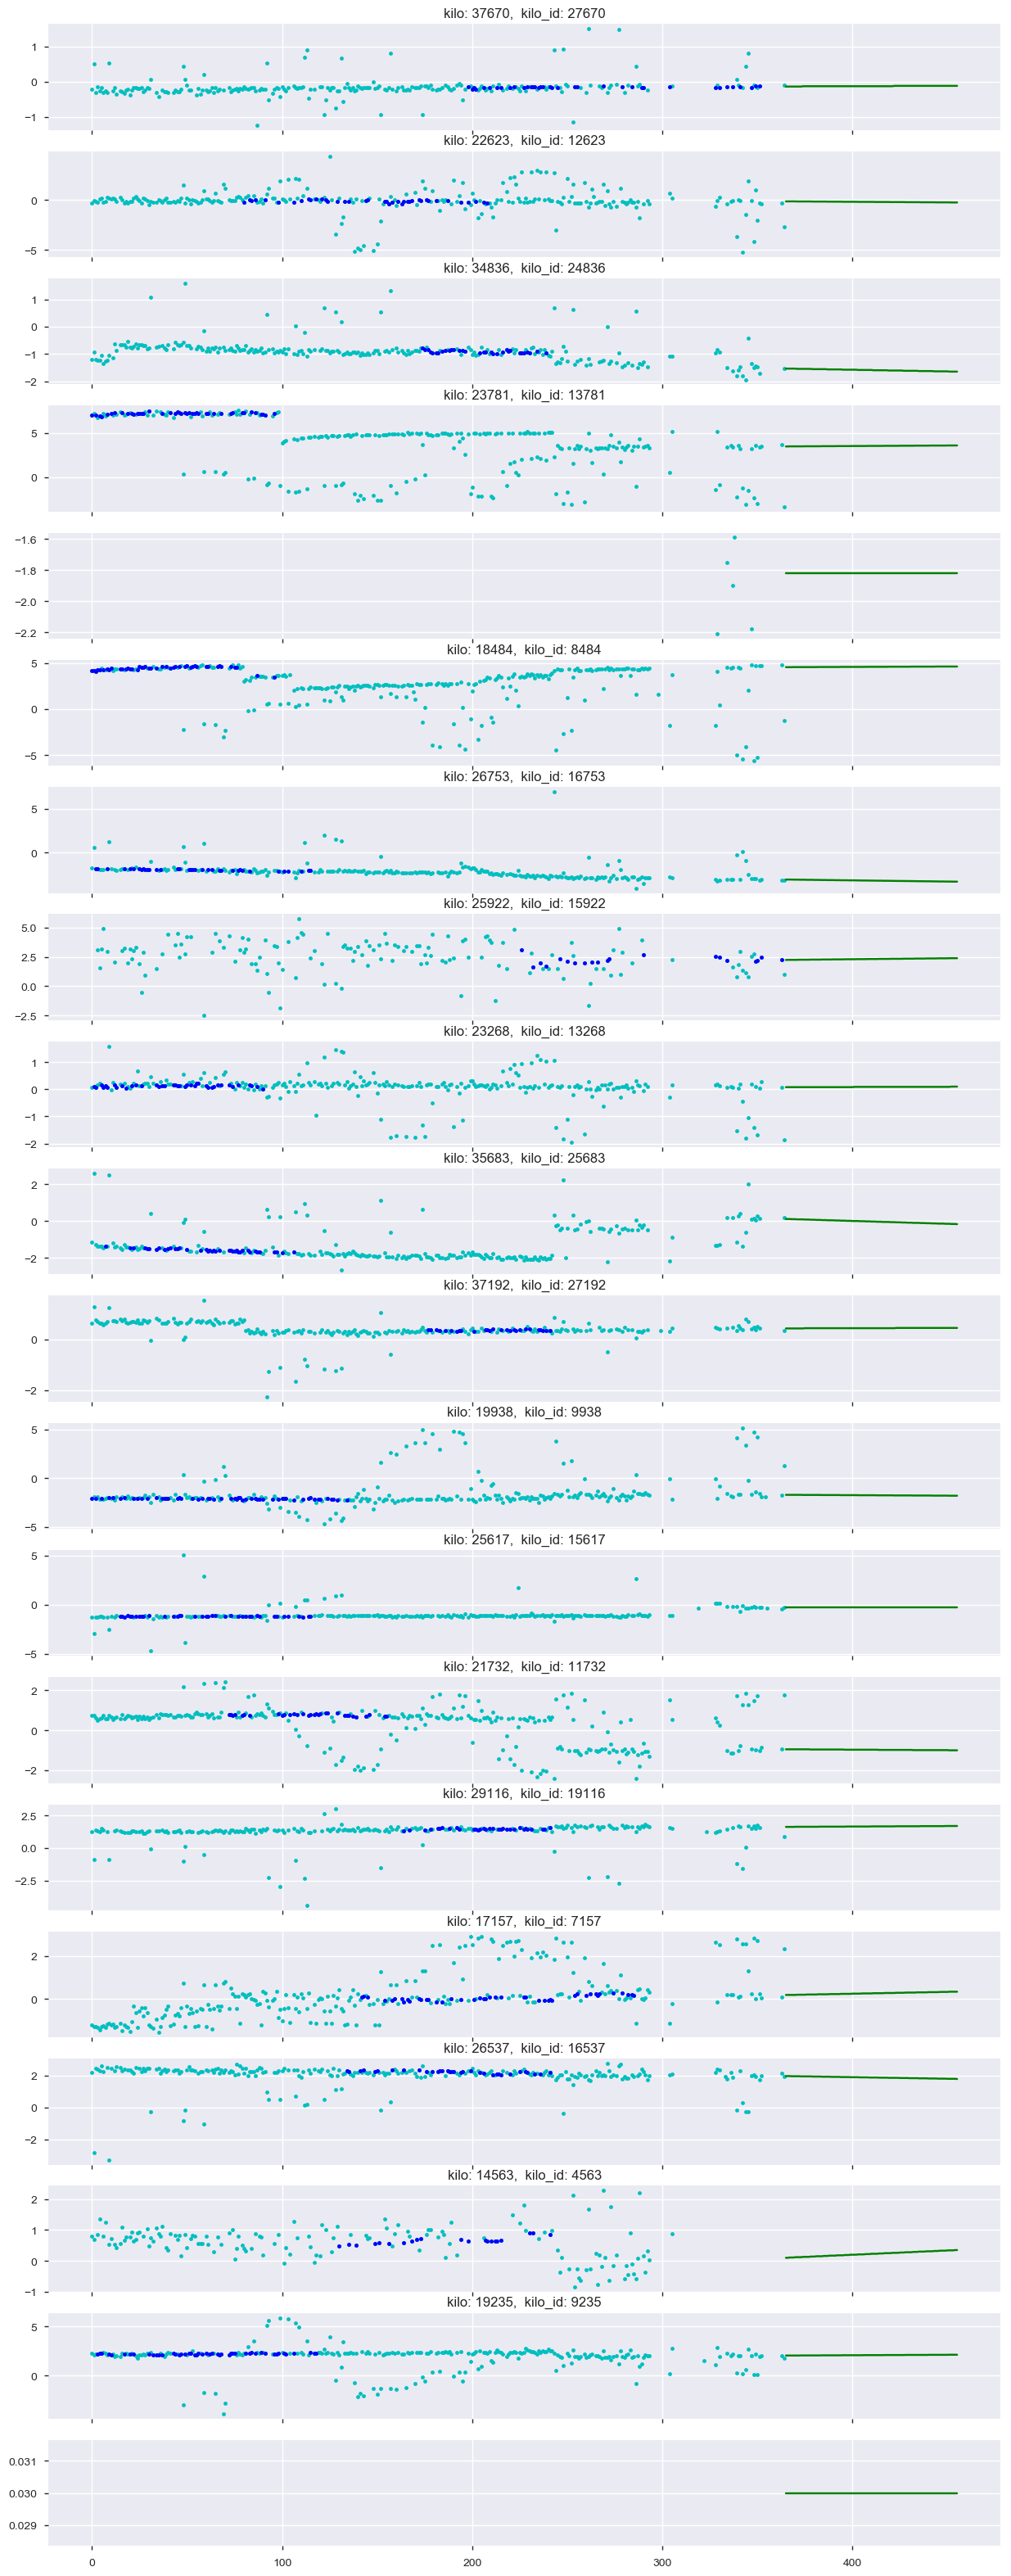

In [81]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['A']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    if len(data) < 10:
        print(i)
        continue
    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 22623,  kilo_id: 12623')

Text(0.5, 1.0, 'kilo: 23781,  kilo_id: 13781')

Text(0.5, 1.0, 'kilo: 11326,  kilo_id: 1326')

Text(0.5, 1.0, 'kilo: 18484,  kilo_id: 8484')

Text(0.5, 1.0, 'kilo: 26753,  kilo_id: 16753')

Text(0.5, 1.0, 'kilo: 25922,  kilo_id: 15922')

Text(0.5, 1.0, 'kilo: 23268,  kilo_id: 13268')

Text(0.5, 1.0, 'kilo: 19938,  kilo_id: 9938')

Text(0.5, 1.0, 'kilo: 25617,  kilo_id: 15617')

Text(0.5, 1.0, 'kilo: 21732,  kilo_id: 11732')

Text(0.5, 1.0, 'kilo: 29116,  kilo_id: 19116')

Text(0.5, 1.0, 'kilo: 17157,  kilo_id: 7157')

Text(0.5, 1.0, 'kilo: 26537,  kilo_id: 16537')

Text(0.5, 1.0, 'kilo: 14563,  kilo_id: 4563')

Text(0.5, 1.0, 'kilo: 19235,  kilo_id: 9235')

Text(0.5, 1.0, 'kilo: 14579,  kilo_id: 4579')

Text(0.5, 1.0, 'kilo: 13107,  kilo_id: 3107')

Text(0.5, 1.0, 'kilo: 30262,  kilo_id: 20262')

Text(0.5, 1.0, 'kilo: 18208,  kilo_id: 8208')

Text(0.5, 1.0, 'kilo: 27451,  kilo_id: 17451')

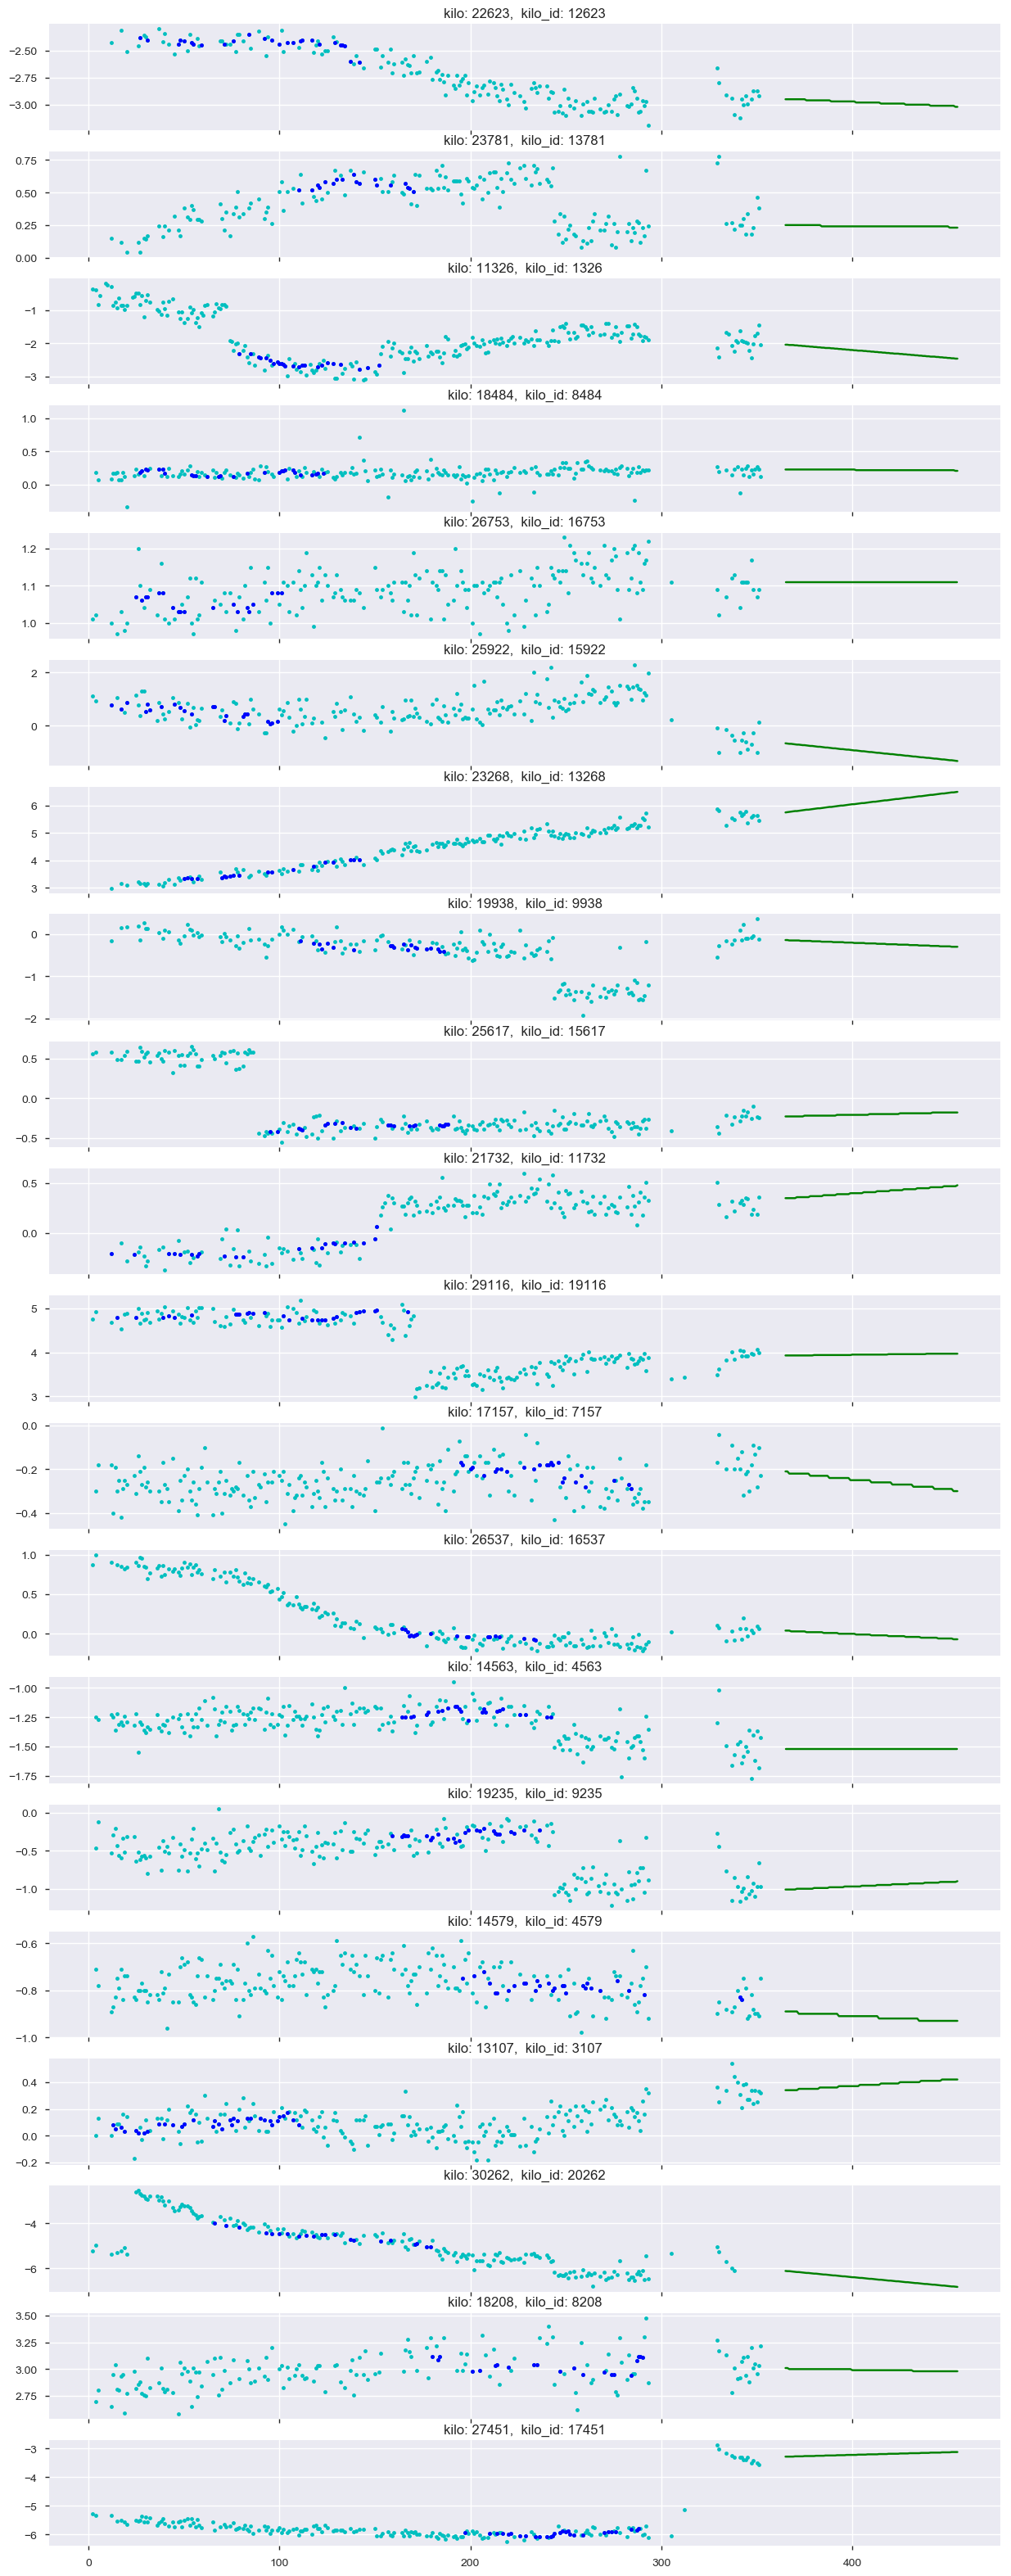

In [82]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['B']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    if len(data) < 10:
        print(i)
        continue
    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 65340,  kilo_id: 55340')

Text(0.5, 1.0, 'kilo: 35247,  kilo_id: 25247')

Text(0.5, 1.0, 'kilo: 59673,  kilo_id: 49673')

Text(0.5, 1.0, 'kilo: 37562,  kilo_id: 27562')

Text(0.5, 1.0, 'kilo: 12653,  kilo_id: 2653')

Text(0.5, 1.0, 'kilo: 26968,  kilo_id: 16968')

Text(0.5, 1.0, 'kilo: 43506,  kilo_id: 33506')

Text(0.5, 1.0, 'kilo: 41845,  kilo_id: 31845')

Text(0.5, 1.0, 'kilo: 36537,  kilo_id: 26537')

Text(0.5, 1.0, 'kilo: 61367,  kilo_id: 51367')

Text(0.5, 1.0, 'kilo: 64385,  kilo_id: 54385')

Text(0.5, 1.0, 'kilo: 29877,  kilo_id: 19877')

Text(0.5, 1.0, 'kilo: 41234,  kilo_id: 31234')

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (9). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))


Text(0.5, 1.0, 'kilo: 33465,  kilo_id: 23465')

Text(0.5, 1.0, 'kilo: 48232,  kilo_id: 38232')

Text(0.5, 1.0, 'kilo: 24315,  kilo_id: 14315')

Text(0.5, 1.0, 'kilo: 43075,  kilo_id: 33075')

Text(0.5, 1.0, 'kilo: 19127,  kilo_id: 9127')

Text(0.5, 1.0, 'kilo: 28470,  kilo_id: 18470')

Text(0.5, 1.0, 'kilo: 19158,  kilo_id: 9158')

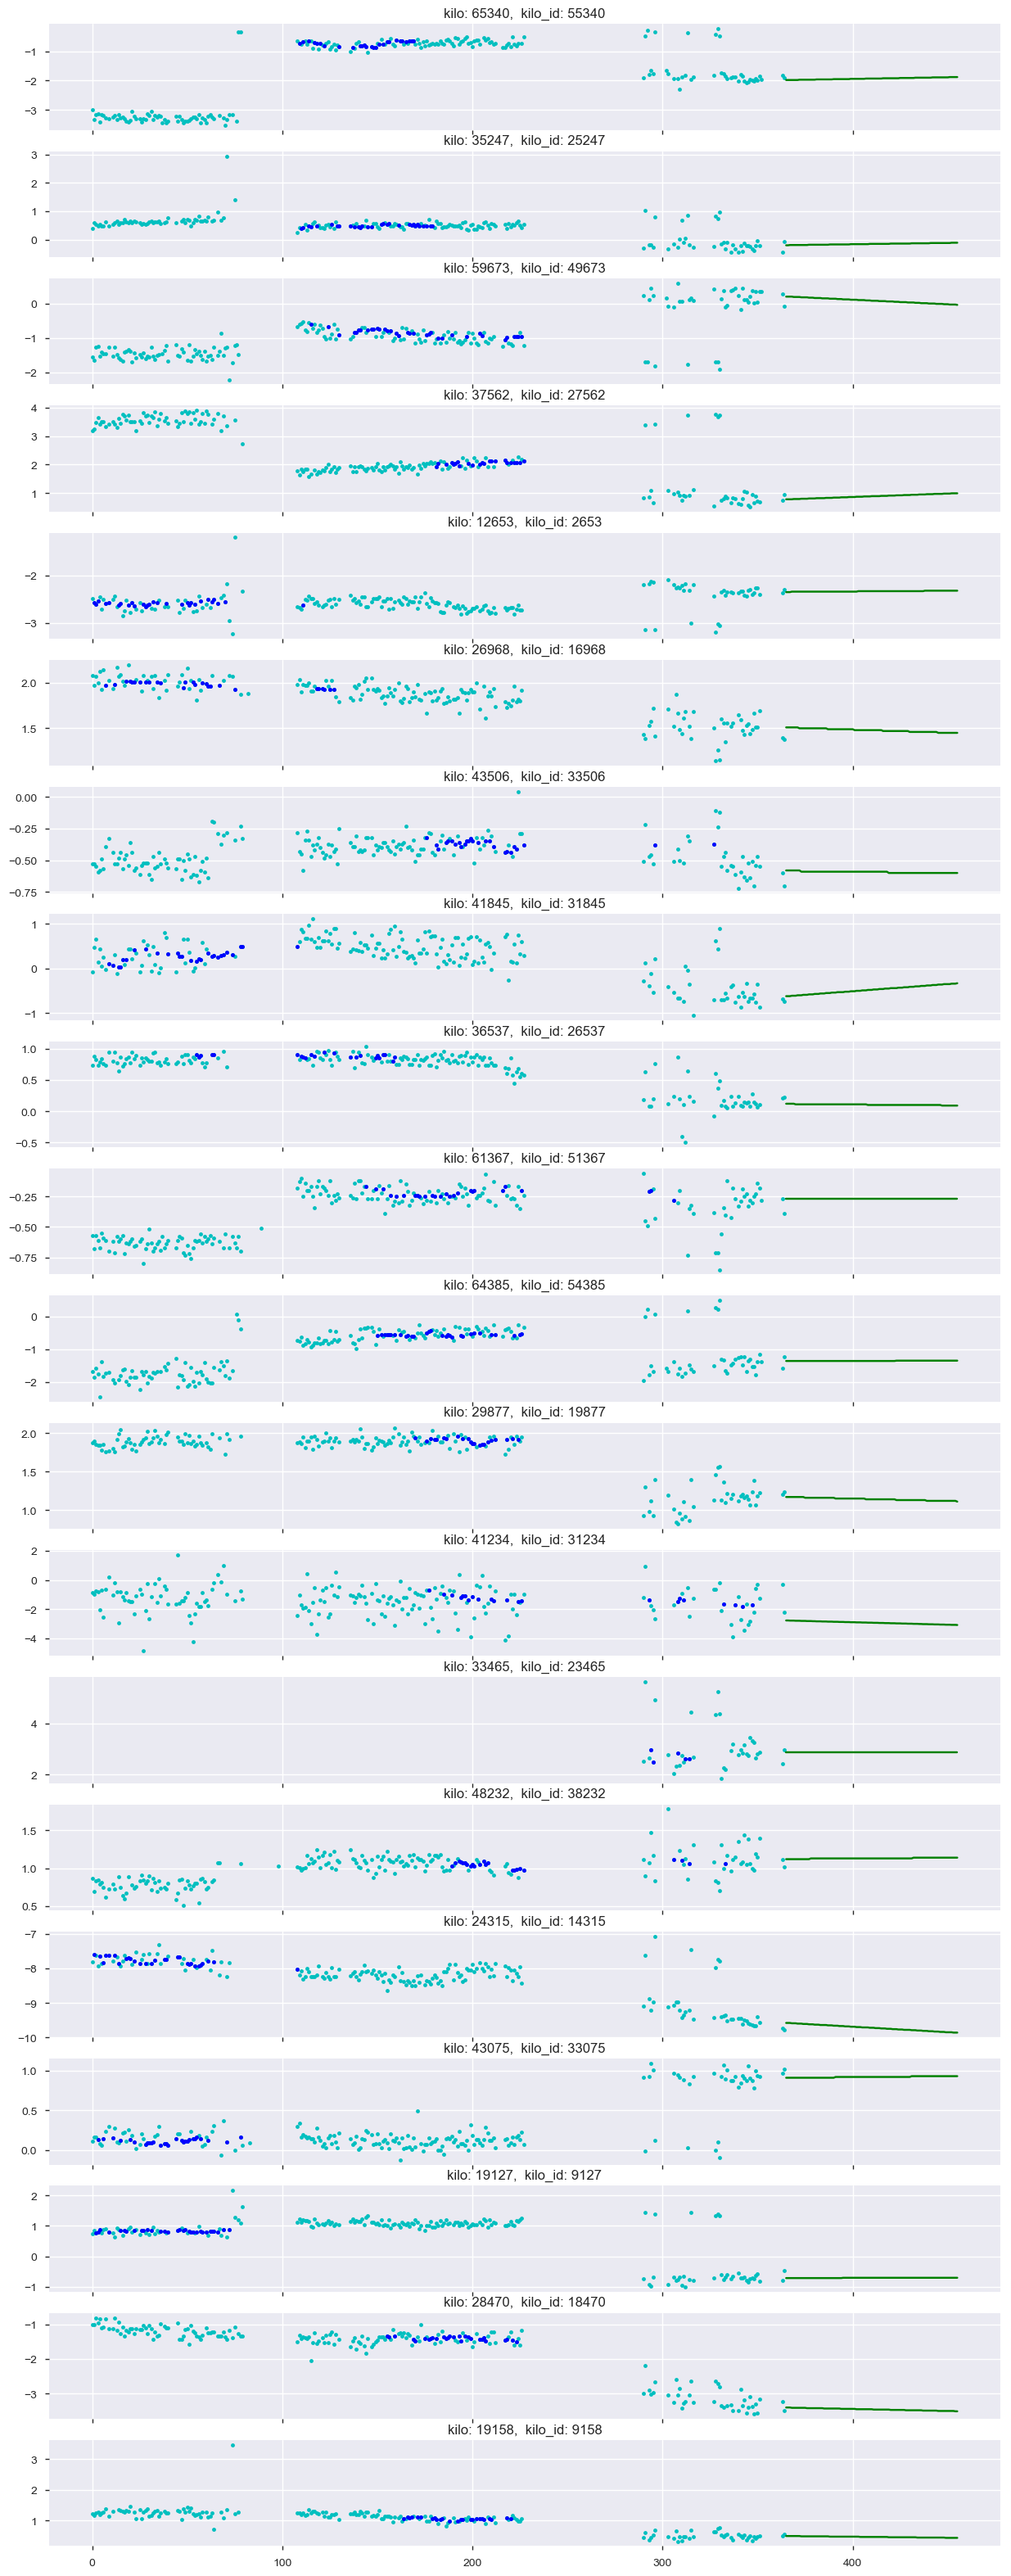

In [83]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['C']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    if len(data) < 10:
        print(i)
        continue
    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 23835,  kilo_id: 13835')

Text(0.5, 1.0, 'kilo: 16311,  kilo_id: 6311')

Text(0.5, 1.0, 'kilo: 22418,  kilo_id: 12418')

Text(0.5, 1.0, 'kilo: 24585,  kilo_id: 14585')

Text(0.5, 1.0, 'kilo: 16890,  kilo_id: 6890')

Text(0.5, 1.0, 'kilo: 10663,  kilo_id: 663')

Text(0.5, 1.0, 'kilo: 14242,  kilo_id: 4242')

Text(0.5, 1.0, 'kilo: 18376,  kilo_id: 8376')

Text(0.5, 1.0, 'kilo: 17961,  kilo_id: 7961')

Text(0.5, 1.0, 'kilo: 16634,  kilo_id: 6634')

Text(0.5, 1.0, 'kilo: 25044,  kilo_id: 15044')

Text(0.5, 1.0, 'kilo: 22841,  kilo_id: 12841')

Text(0.5, 1.0, 'kilo: 23596,  kilo_id: 13596')

Text(0.5, 1.0, 'kilo: 14969,  kilo_id: 4969')

Text(0.5, 1.0, 'kilo: 17808,  kilo_id: 7808')

Text(0.5, 1.0, 'kilo: 15866,  kilo_id: 5866')

Text(0.5, 1.0, 'kilo: 19558,  kilo_id: 9558')

Text(0.5, 1.0, 'kilo: 24608,  kilo_id: 14608')

Text(0.5, 1.0, 'kilo: 24878,  kilo_id: 14878')

Text(0.5, 1.0, 'kilo: 13578,  kilo_id: 3578')

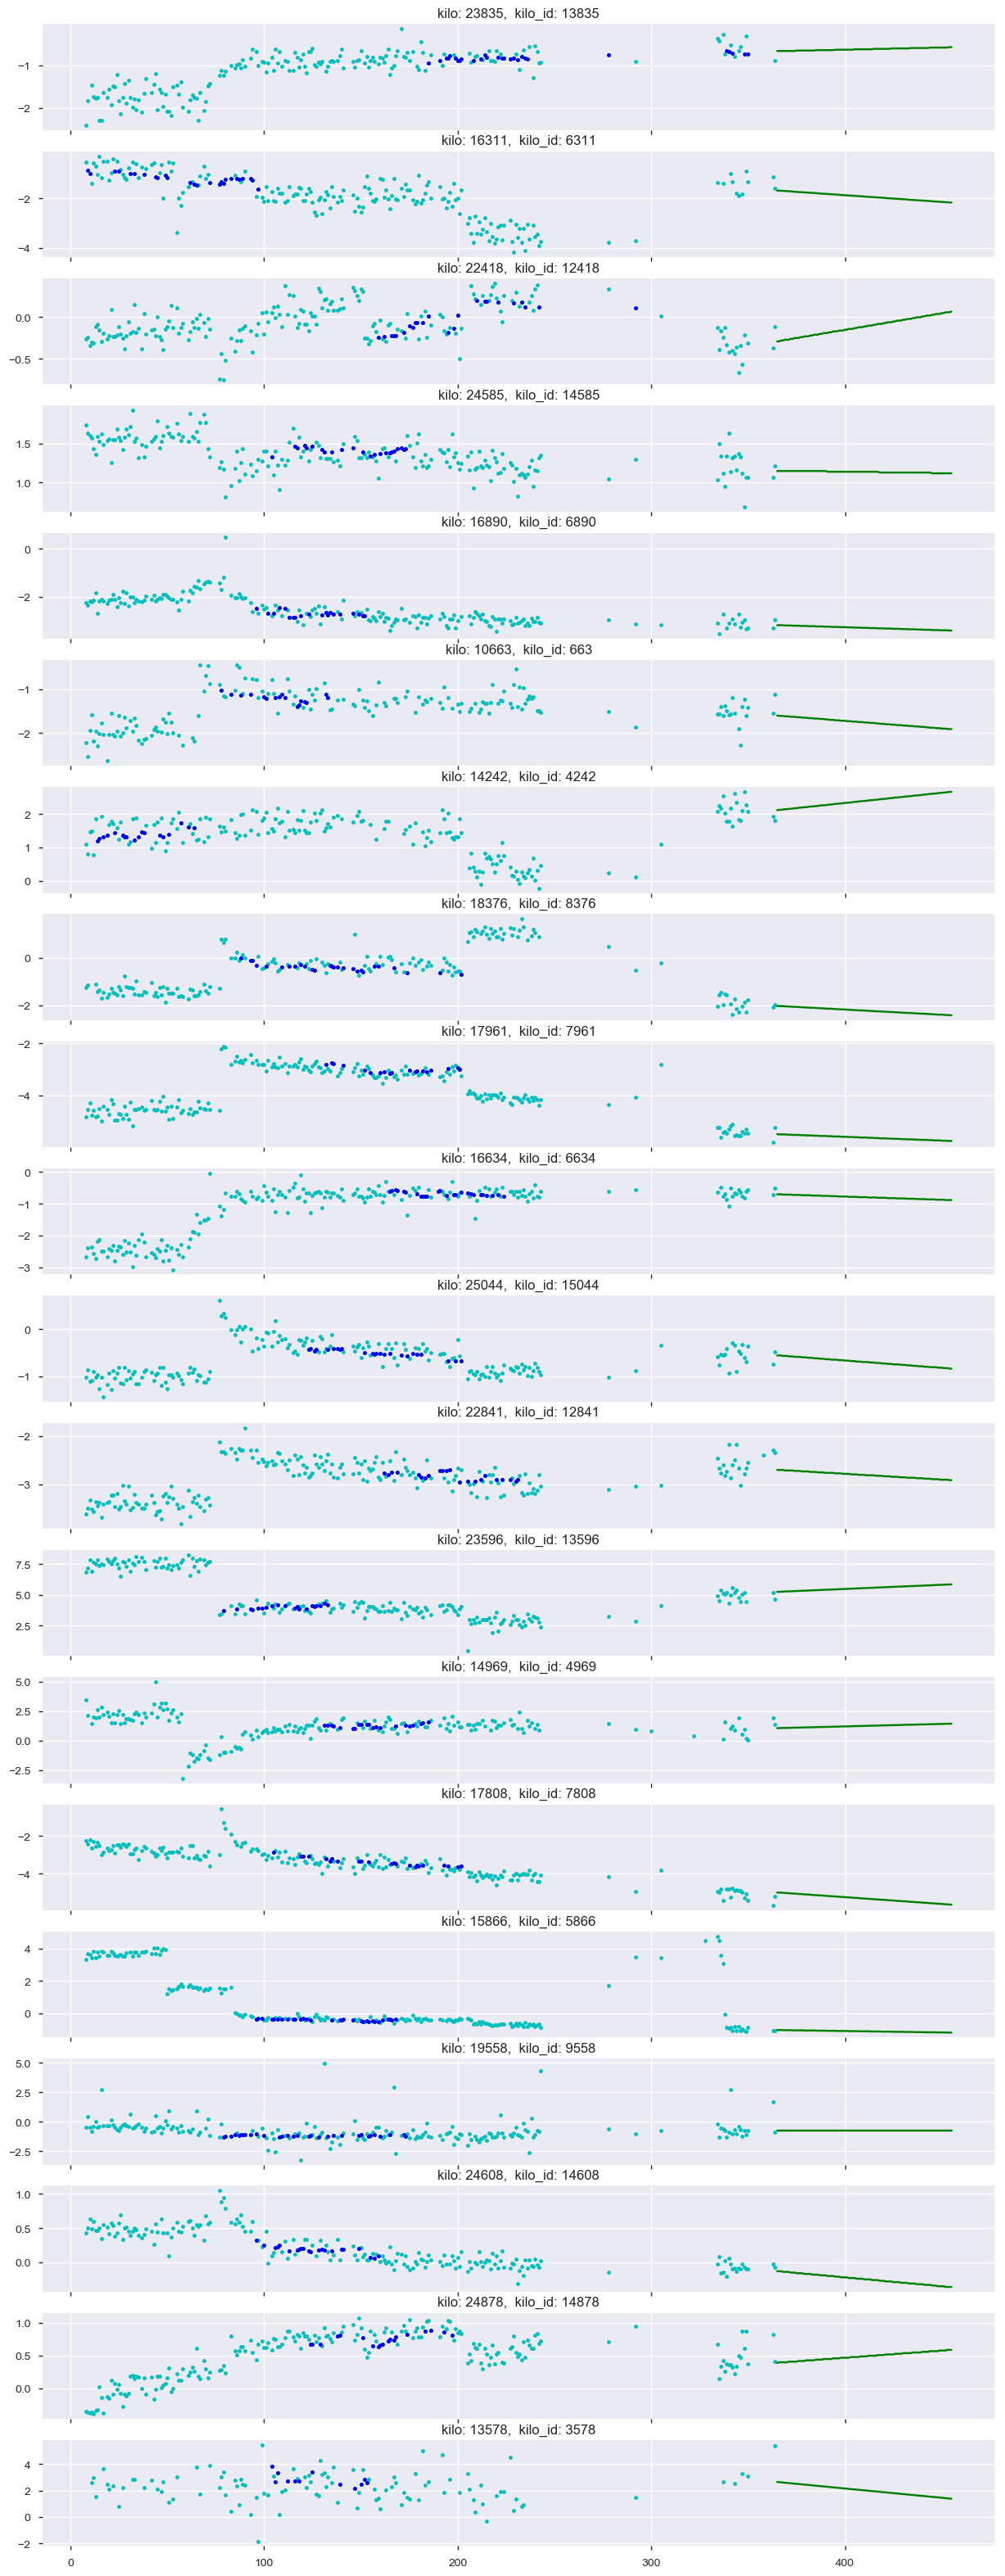

In [84]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['D']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91 + len(tracks['C']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    if len(data) < 10:
        print(i)
        continue
    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

In [85]:
submision.to_csv("submit5.csv", header=None)